# SD701 Data Mining
Par Pierre Dal Bianco et Nicolas Esdras

In [1]:
# we do our imports
import sklearn as sk
import numpy as np
from sklearn import cluster
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# on définit une palette de couleur personnalisée
plt.style.use('seaborn-bright')

## Partie 1 : exploration du dataset
Le jeu de données provient du site Kaggle : https://www.kaggle.com/tiagotgoz/predictive-useful-life-based-into-telemetry

Il contient 24h de cycle sur 100 machines avec des données de capteurs et des d'autres données sur l'état des machines. La liste exhaustive des colonnes est la suivante :
- machineID : ID de la machine
- datetime : Date de télémétrie
- timeincycles : Lecture de cycle
- voltmean24h : Moyenne télémétrique en volt des dernières 24h
- rotatemean24h : Moyenne télémétrique en rotation des dernières 24h
- pressuremean24h : Moyenne de télémétrie de pression des dernières 24h
- vibrationmean24h : Moyenne de télémétrie de vibration des dernières 24h
- voltsd24h : Écart-type de télémétrie Volt des dernières 24h
- rotatesd24h : Écart-type de télémétrie rotation des dernières 24h
- pressuresd24h : Écart-type de télémétrie de pression des dernières 24h
- vibrationsd24h : Écart-type de télémétrie de vibration des dernières 24h
- voltmean5d : Moyenne télémétrique en volt des 5 derniers jours
- rotatemean5d :Moyenne télémétriquee rotation des 5 derniers jours
- pressuremean5d : Moyenne de télémétrie de pression des 5 derniers jours
- vibrationmean5d : Moyenne de télémétrie de vibration des 5 derniers jours
- voltsd5d : Écart-type de télémétrie Volt des 5 derniers jours
- rotatesd5d : Écart-type de télémétrie rotation des 5 derniers jours
- Pressuresd5d : Écart-type de télémétrie de pression des 5 derniers jours
- vibrationsd5d : Écart-type de télémétrie de vibration des 5 derniers jours
- error1 : Identification de l'erreur 1
- error2 : Identification de l'erreur 2
- error3 : Identification de l'erreur 3
- error4 : Identification de l'erreur 4
- error5 : Identification de l'erreur 5
- comp1 : Cycle de maintenance du composant 1
- comp2 : Cycle de maintenance du composant 2
- comp3 : Cycle de maintenance du composant 3
- comp4 : Cycle de maintenance du composant 4
- model : Modèle de machine
- age : Âge de la machine
- RUWeek : Temps en semaines pour l'échec
- failure : Identification du composant qui a échoué
- failed : Échec ou non
- RUL : Durée de vie utile restante en cycles par panne et machine
- RUL_I : RUL inverse 

On constate qu'il existe un nombre important de colonnes dans notre jeu de données. Cependant un certain nombre de variables sont calculées à partir d'autres variables. Dans un environnement industriel, on peut surtout s'attendre à avoir accès aux variables numériques ```voltmean_24h```, ```rotatemean_24h```, ```pressuremean_24h```, ```vibrationmean_24h``` et ```time_in_cycles```. Les autres variables numériques sont calculées à partir de celles ci. Nous allons donc dans un premier temps nous pencher sur les variations de ces variables au cours du temps. Nous allons biensûre également jeter un oeil à la variable que nous cherchons à expliquer ```failure```.

In [2]:
# we read the csv file
data = pd.read_csv("ALLtrainMescla5D.csv.zip")

# we convert the failure variable into a number which represents the type of failure with 0 = no failure
data['failure'] = data['failure'].map({'none':0, 'comp1':1,  'comp2':2,  'comp3':3,  'comp4':4})

# we convert the datetime column into a datetime data type
data['datetime'] = data['datetime'].apply(lambda d: datetime.datetime.strptime(d, '%Y-%m-%d'))
data = data.sort_values('datetime', ignore_index=True)
data.head()

machineID   datetime  time_in_cycles  voltmean_24h  rotatemean_24h  \
0         95 2015-01-05               1    165.150466      450.662536   
1         44 2015-01-05               1    194.124565      456.674033   
2         46 2015-01-05               1    168.455471      440.367124   
3          9 2015-01-05               1    164.165611      402.663447   
4         55 2015-01-05               1    171.563096      451.281569   

   pressuremean_24h  vibrationmean_24h  voltsd_24h  rotatesd_24h  \
0         93.896161          39.475158   14.071702     42.993861   
1         98.853944          40.606549   14.244891     65.204125   
2        100.849685          39.104371   15.977724     52.985321   
3         98.894203          39.399287   15.243251     48.649790   
4        100.017165          39.139113   13.238429     61.624450   

   pressuresd_24h  ...  comp3  comp4   model  age        DI  RULWeek  failure  \
0        7.916604  ...      0      0  model2   18  2.651351        1        0   
1        9.500017  ...      0      0  model4    7  2.672598        1        0   
2       10.503331  ...      0      0  model4   10  2.701293        1        0   
3        9.412391  ...      0      0  model4    7  2.648086        1        0   
4        9.798919  ...      0      0  model3   17  2.653564        1        0   

   failed  RUL  RUL_I  
0       0    1     45  
1       0    1     70  
2       0    1     48  
3       0    1     58  
4       0    1     61  

[5 rows x 36 columns]

De combien de points de données disposons-nous ?

In [3]:
data.shape

(28056, 36)

Est-ce que nous avons les types de données attendues ?

In [4]:
# let's check the types
data.dtypes

machineID                     int64
datetime             datetime64[ns]
time_in_cycles                int64
voltmean_24h                float64
rotatemean_24h              float64
pressuremean_24h            float64
vibrationmean_24h           float64
voltsd_24h                  float64
rotatesd_24h                float64
pressuresd_24h              float64
vibrationsd_24h             float64
voltmean_5d                 float64
rotatemean_5d               float64
pressuremean_5d             float64
vibrationmean_5d            float64
voltsd_5d                   float64
rotatesd_5d                 float64
pressuresd_5d               float64
vibrationsd_5d              float64
error1                        int64
error2                        int64
error3                        int64
error4                        int64
error5                        int64
comp1                         int64
comp2                         int64
comp3                         int64
comp4                       

Combien de machines différentes est-ce que nous avons ?

In [5]:
print('{} valeurs uniques entre {} et {}'.format(data['machineID'].nunique(), data['machineID'].min(), data['machineID'].max()))

98 valeurs uniques entre 1 et 100


Il semble qu'il y ait deux ID inexistants puisqu'on a 98 valeurs entre 1 et 100, essayons de les identifier

In [6]:
# this returns the elements missing, we are hoping to find none
print('Les deux valeurs manquantes sont {}'.format(set(range(1, 100)) - set(data['machineID'].unique())))

Les deux valeurs manquantes sont {77, 6}


Quel est l'age moyen de chaque machine ?

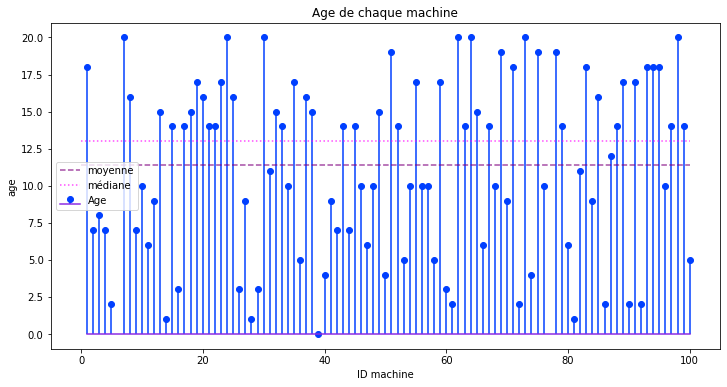

In [7]:
plt.figure(figsize=(12,6))
machines_age = data.groupby('machineID')['age'].mean()
plt.stem(machines_age.index, machines_age, label='Age');
plt.hlines(machines_age.mean(), xmin=0, xmax=100, linestyle='dashed', color='purple', alpha=0.7, label='moyenne')
plt.hlines(machines_age.median(), xmin=0, xmax=100, linestyle = 'dotted', color='magenta', alpha=0.7, label='médiane')
plt.xlabel('ID machine')
plt.ylabel('age')
plt.title('Age de chaque machine');
plt.legend();

Les mesures ont été réalisées sur quelle période de temps ?

In [8]:
print('Première mesure : {}'.format(data['datetime'].min()))
print('Durée totale des mesures : {}'.format((data['datetime'].max() - data['datetime'].min())))

Première mesure : 2015-01-05 00:00:00
Durée totale des mesures : 360 days 00:00:00


Y-a-t-il des dates manquantes dans les mesures ?

In [9]:
# this returns the elements missing, we are hoping to find none
pd.date_range(start = data['datetime'].min(), end = data['datetime'].max(), freq='d').difference(data['datetime'])

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

Y-a-t-il des duplicats ?

In [10]:
data.duplicated().any()

False

Y-a-t-il des valeurs nulles / na ?

In [11]:
data.isna().any().any()

False

Affichons quelques graphes sur les données de mesures ```voltmean_24h```, ```rotatemean_24h```, ```pressuremean_24h```, et ```vibrationmean_24h``` sur 4 machines tirées aléatoirement pour voir à quoi cela ressemble

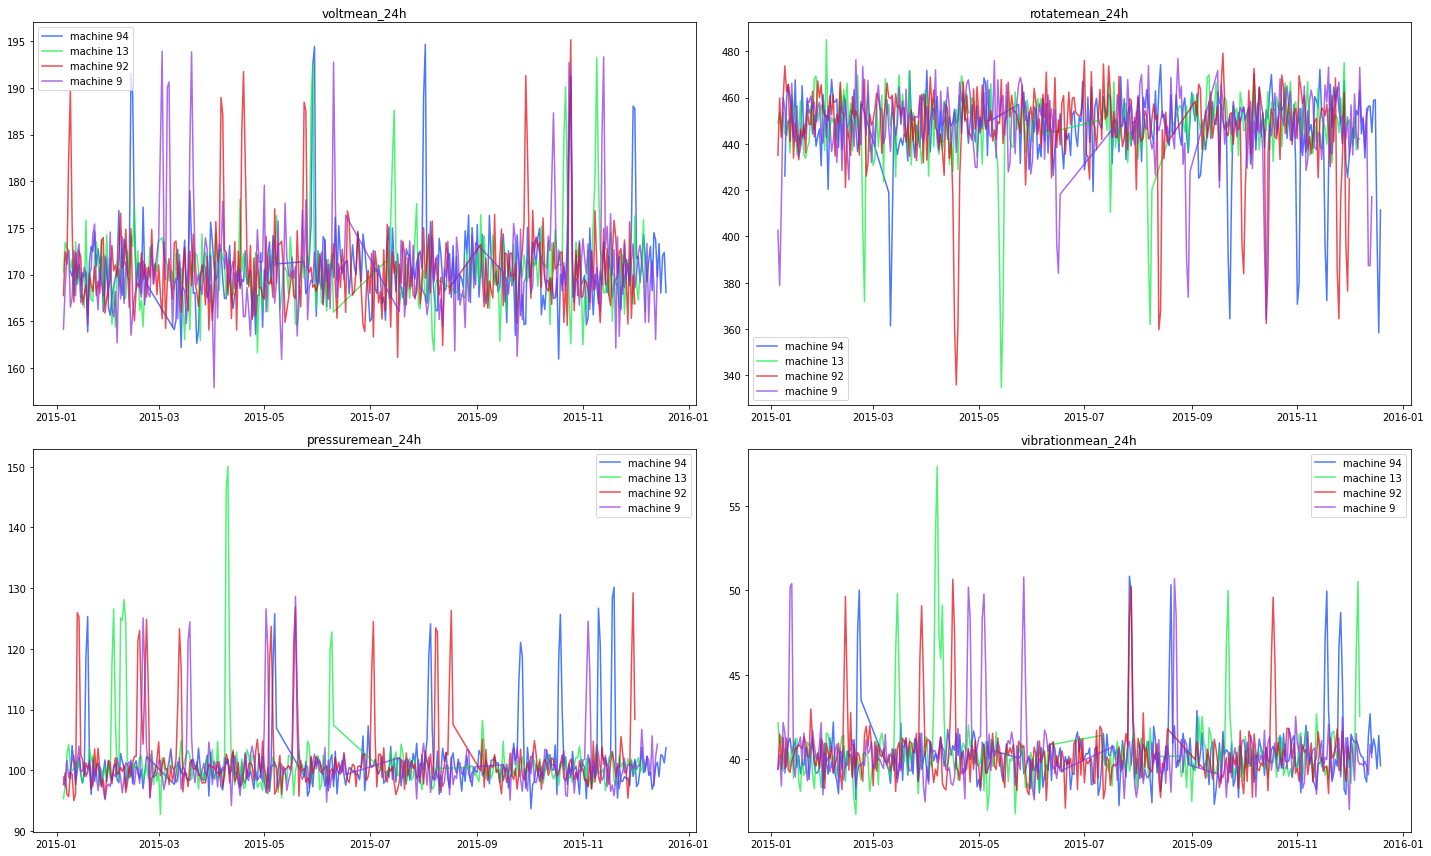

In [12]:
# we prepare our plot
fig = plt.figure(figsize=(20, 12));
k = 1

machineID = np.random.choice(data['machineID'].unique(), 4)
columns_graph = ['voltmean_24h', 'rotatemean_24h', 'pressuremean_24h', 'vibrationmean_24h']

# for each column
for col in columns_graph:
    # we add a subplot
    ax = fig.add_subplot(2, 2, k)
    # we plot the categories in each subplot
    for id in machineID:
        ax.plot(data.loc[data['machineID'] == id, 'datetime'],
                data.loc[data['machineID'] == id, col],
                label = 'machine ' + str(id), alpha=0.7);
        ax.set_title(col);
    #ax.autoscale(axis='x',tight=True);
    ax.legend();
    k+=1
fig.tight_layout()

Il semble y avoir des données lissées sur plusieurs jours, nous allons voir si cela a un impacte sur nos prédictions. Essayons de voir l'évolution des différentes grandeurs numériques au cours du temps. Nous allons rajouter le nombre de pannes en arrière plan de chaque graphique.

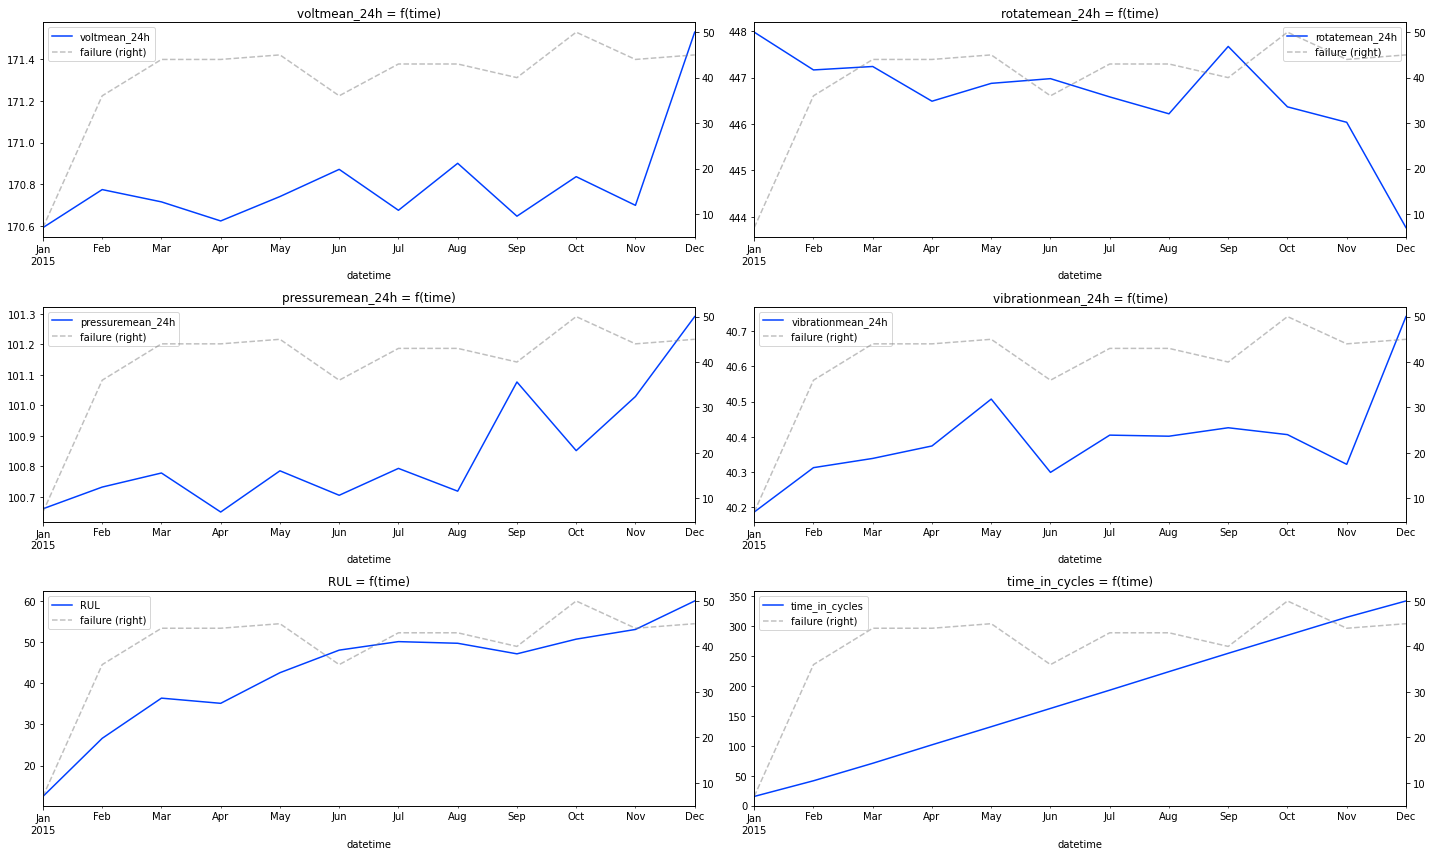

In [13]:
columns_graph = ['voltmean_24h', 'rotatemean_24h', 'pressuremean_24h', 'vibrationmean_24h', 'RUL', 'time_in_cycles']
data_resampled = data.resample(rule='M', on='datetime').mean()[columns_graph].interpolate(method='linear')
data_failure_resampled = data[data['failure'] > 0].resample(rule='M', on='datetime').count()['failure'].interpolate(method='linear')

# we prepare our plot
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 12))

k=0
# we plot the column data in each subplot
for i in range(3):
    for j in range(2):
        data_resampled[columns_graph[k]].plot(ax=axes[i,j], legend=columns_graph[k]);
        data_failure_resampled.plot(secondary_y=True, ax=axes[i,j], legend='failures count', alpha=0.5, linestyle='dashed', color='gray');
        axes[i,j].set_title(columns_graph[k]+' = f(time)')
        k+=1
fig.tight_layout();

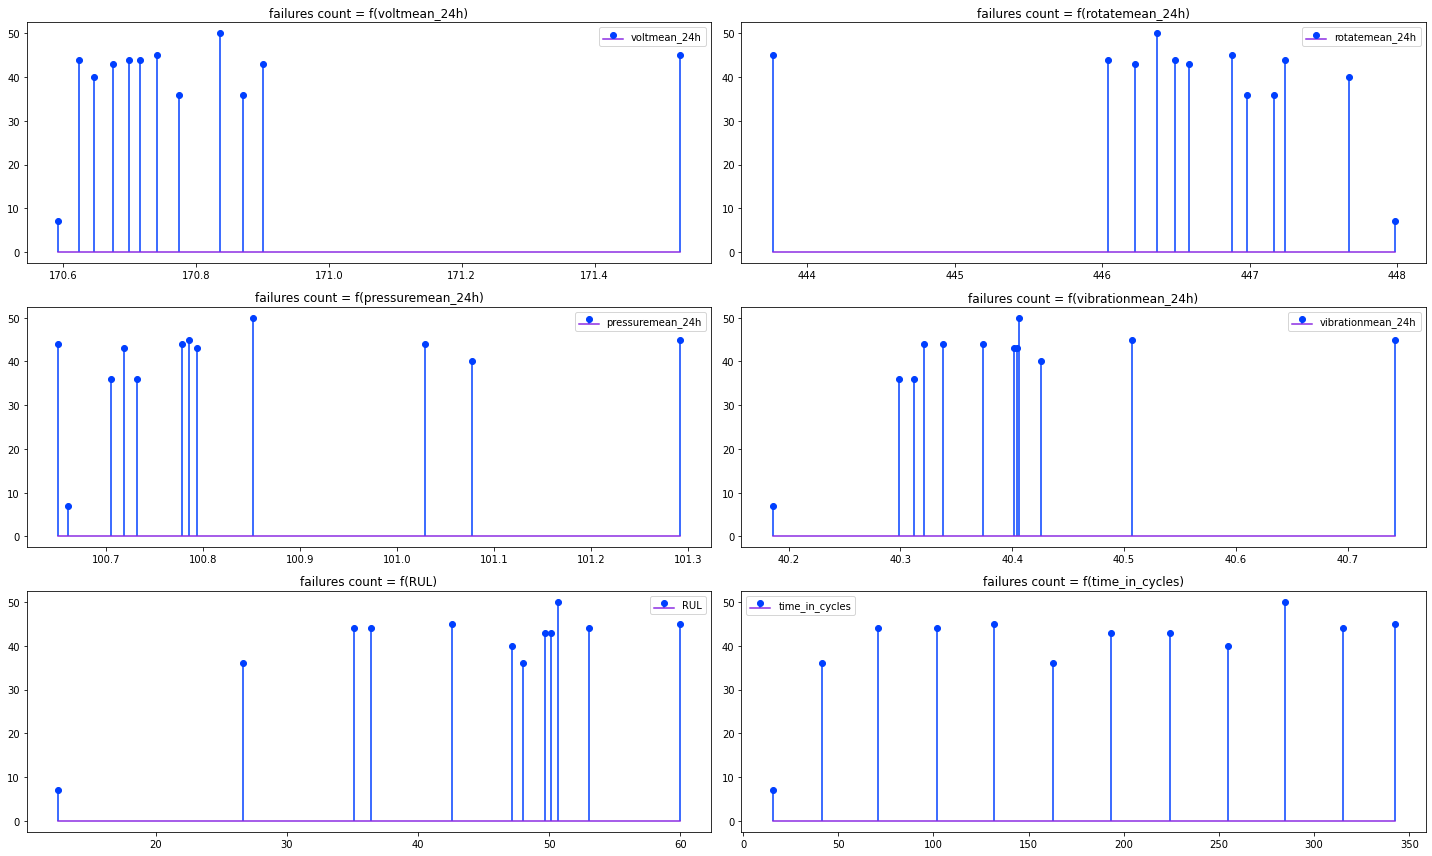

In [14]:
columns_graph = ['voltmean_24h', 'rotatemean_24h', 'pressuremean_24h', 'vibrationmean_24h', 'RUL', 'time_in_cycles']
data_resampled = data.resample(rule='M', on='datetime').mean()[columns_graph].interpolate(method='linear')
data_failure_resampled = data[data['failure'] > 0].resample(rule='M', on='datetime').count()['failure'].interpolate(method='linear')

# we prepare our plot
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 12))

k=0
# we plot the column data in each subplot
for i in range(3):
    for j in range(2):
        axes[i,j].stem(data_resampled[columns_graph[k]], data_failure_resampled,label=columns_graph[k]);
        #data_failure_resampled.plot(secondary_y=True, ax=axes[i,j], legend='failures count', alpha=0.5, linestyle='dashed', color='gray');
        axes[i,j].set_title('failures count = f('+ columns_graph[k] +')')
        axes[i,j].legend()
        k+=1
fig.tight_layout();

On peut aussi tracer un histogramme du nombre de panne par type de panne, pour voir s'il y a un type qui apparaît plus souvent. Nous allons tracer la même chose avec le nombre d'erreurs.

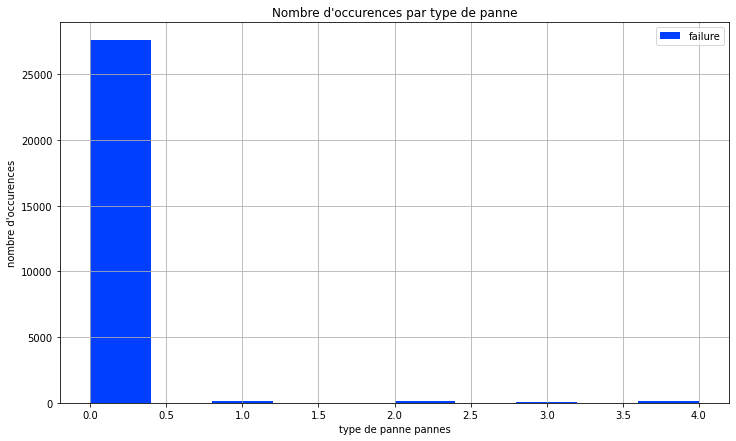

In [15]:
# we prepare our plot
data['failure'].hist(figsize=(12, 7), legend='failure');
plt.xlabel('type de panne pannes')
plt.ylabel('nombre d\'occurences')
plt.title('Nombre d\'occurences par type de panne')
plt.legend();

In [16]:
print('Pourcentage de la classe 0 par rapport aux autres classes : {:.2%}'.format(1 - data.loc[data['failure'] > 0, 'failure'].count()/data['failure'].count()))

Pourcentage de la classe 0 par rapport aux autres classes : 98.30%


On constate déjà une grosse disparité entre les classes et notamment la classe 0 qui correspond au cas où il n'y a pas de pannes (ie fonctionnement normal) puisque la classe 0 représente plus de 98% des effectifs de classe. Il faudrait donc s'orienter vers des algorithmes capable de gérer ces grosses disparités. En complément, on pourra essayer de regrouper tous les échecs dans une même catégorie dans un premier temps afin d'augmenter l'effectif de la classe pour faire classification en deux temps : échec? (True ou False) puis quel type d'échec si failure=True.

On constate cependant qu'il semble y avoir un lien entre le nombre d'erreurs et le nombre de pannes.

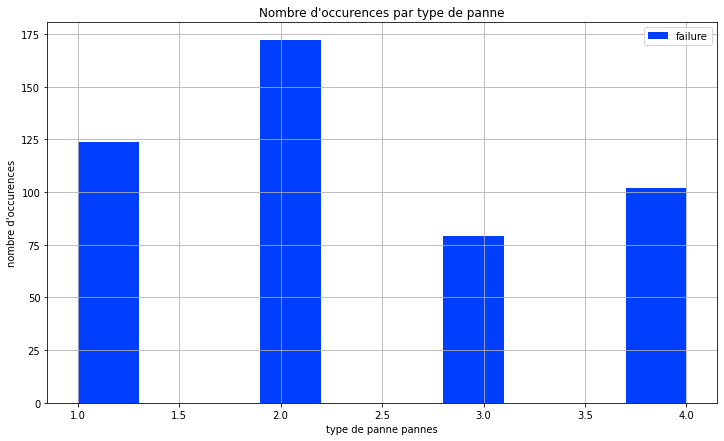

In [17]:
data['failure'][data['failure'] > 0].hist(figsize=(12, 7), legend='failure');
plt.xlabel('type de panne pannes')
plt.ylabel('nombre d\'occurences')
plt.title('Nombre d\'occurences par type de panne');

Affichons un histogramme du nombre d'erreurs simultanées

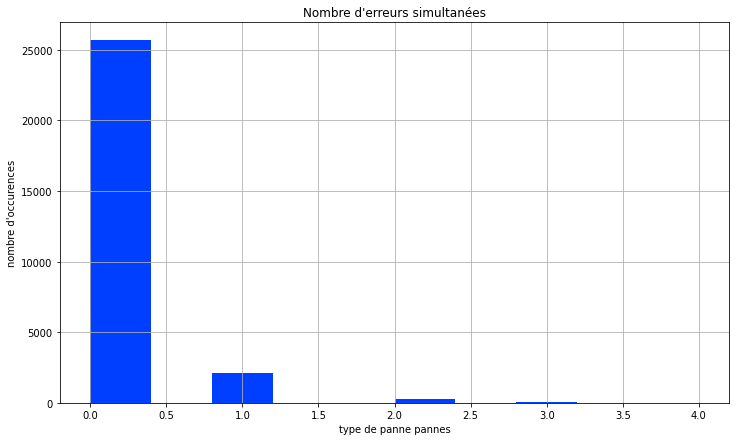

In [18]:
# we prepare our plot
(data['error1']+data['error2']+data['error3']+data['error4']).hist(figsize=(12, 7));
plt.xlabel('type de panne pannes');
plt.ylabel('nombre d\'occurences');
plt.title('Nombre d\'erreurs simultanées');

Le type d'échec une fois la classe 0 (pas d'échec) retirée : les classes échec sont réparties à peu près uniformément à première vue.

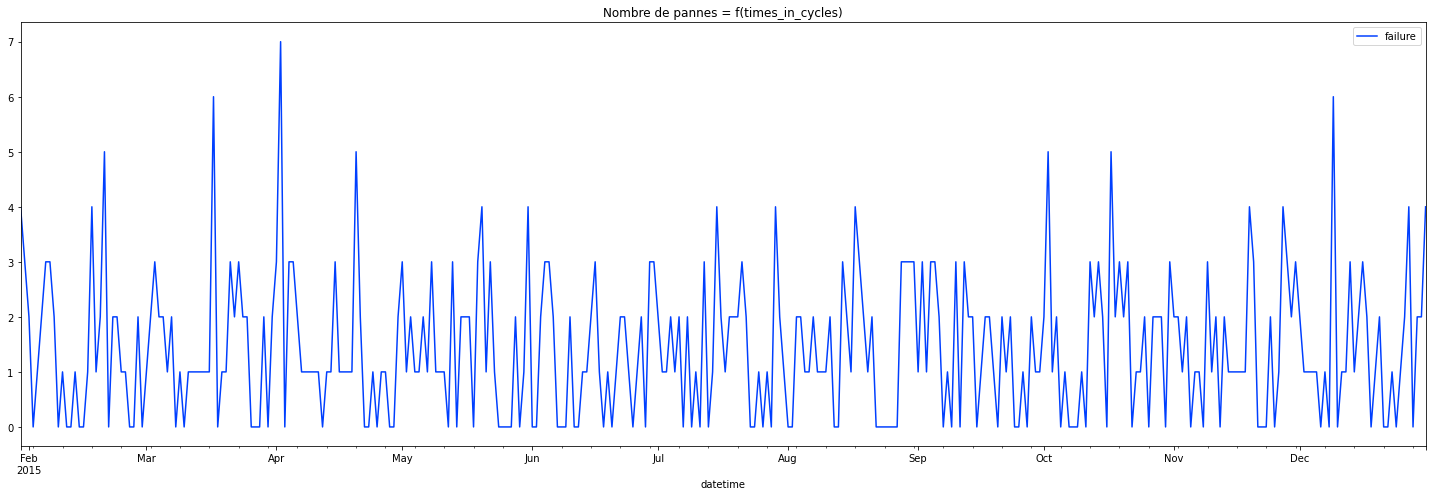

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 7))
data[data['failure'] > 0].resample(rule='D', on='datetime').count()['failure'].interpolate(method='linear').plot(legend='failures', ax=ax);
#ax.set_xticks(np.arange(0, 360, 10));
ax.set_title('Number of failures = f(time)');
ax.legend()
ax.set_title('Nombre de pannes = f(times_in_cycles)');
fig.tight_layout()

Observons comment les différentes covariables intéragissent entre elles et avec la variable à expliquer.

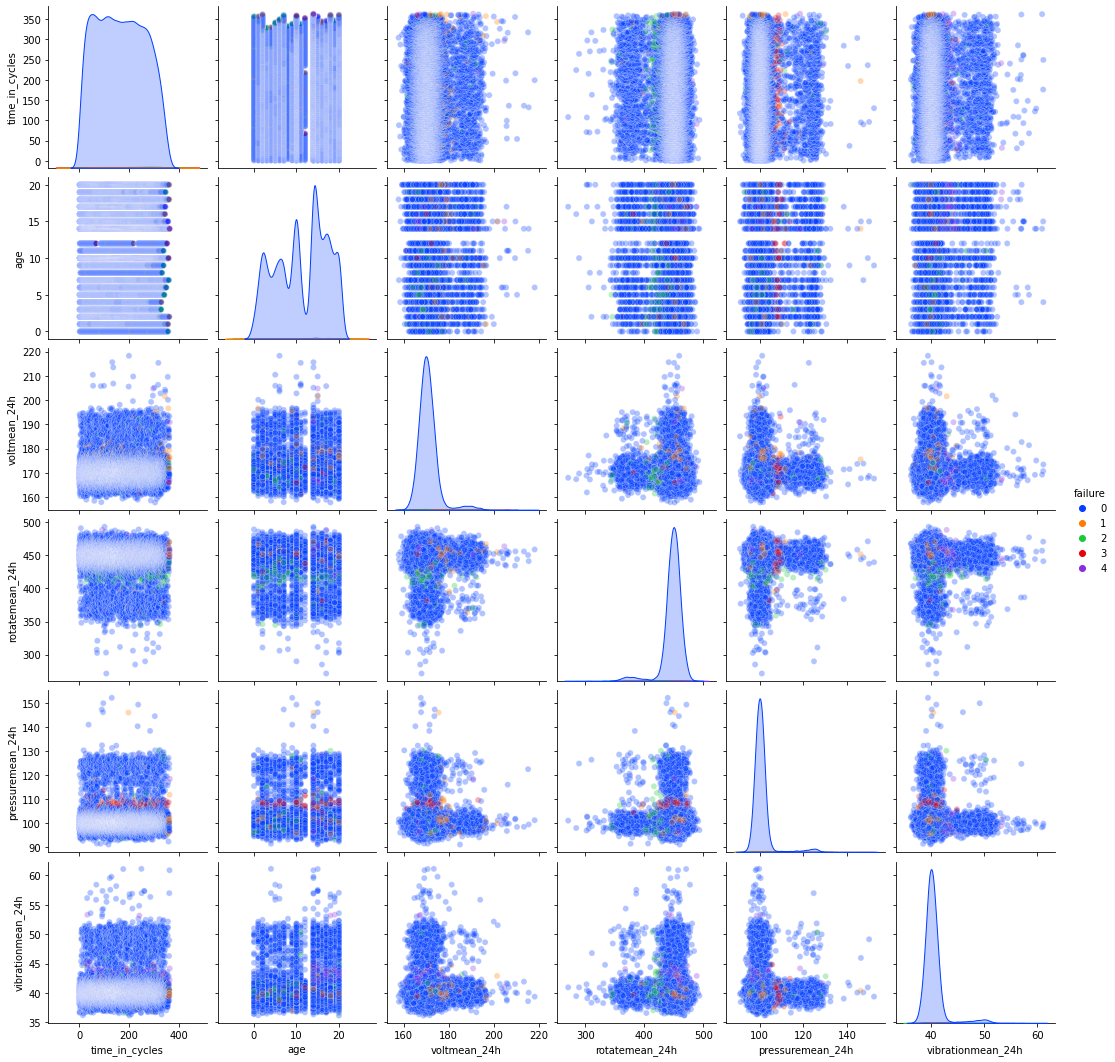

In [20]:
num_columns = ['time_in_cycles', 'age',
               'voltmean_24h', 'rotatemean_24h', 'pressuremean_24h', 'vibrationmean_24h',
               'failure']
sns.pairplot(data[num_columns], hue='failure', plot_kws={'alpha':0.3}, palette='bright');

Observons les mêmes graphes sans la classe failure = 0.

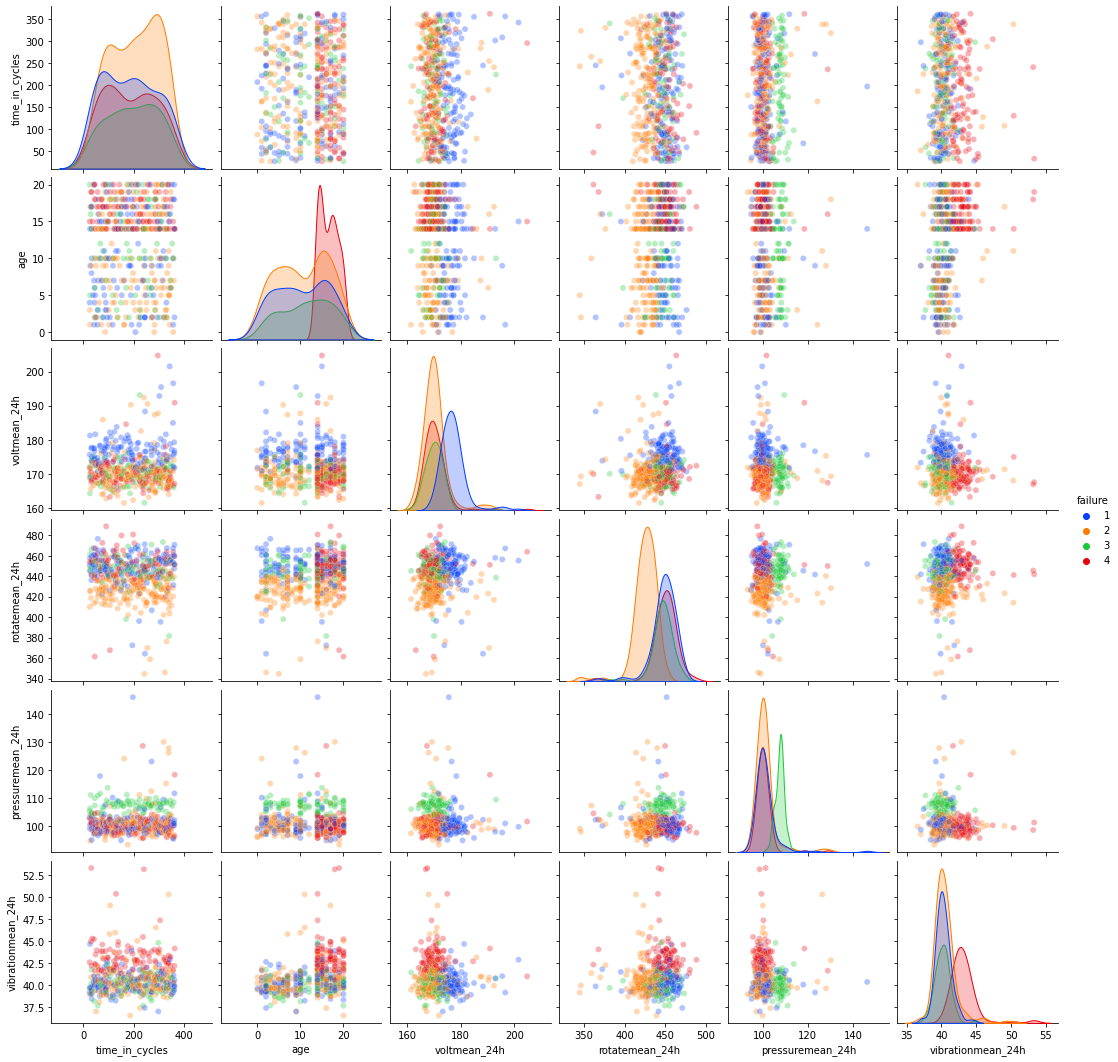

In [21]:
sns.pairplot(data.loc[data['failure'] > 0, num_columns], hue='failure', plot_kws={'alpha':0.3}, palette='bright');

# Partie 2 : Classification
## 1. Split

Avant toutes choses, nous allons découper notre jeu de données pour avoir un jeu d'entrainement et un jeu de test. Le but est de garder un jeu de test isolé du reste de notre analyse. Nous allons fixer le random_state, ce qui sera utilse plus tard pour pouvoir enregistrer un jeu de données déjà découpé en train et test.

In [22]:
all_num_cols = ['time_in_cycles', 'voltmean_24h',
       'rotatemean_24h', 'pressuremean_24h', 'vibrationmean_24h', 'voltsd_24h',
       'rotatesd_24h', 'pressuresd_24h', 'vibrationsd_24h', 'voltmean_5d',
       'rotatemean_5d', 'pressuremean_5d', 'vibrationmean_5d', 'voltsd_5d',
       'rotatesd_5d', 'pressuresd_5d', 'vibrationsd_5d', 'age', 'RUL']
       
all_oh_cols = ['error1', 'error2', 'error3', 'error4', 'error5', 'comp1', 'comp2', 'comp3', 'comp4']
       
data_train = data.sample(frac=0.8, random_state=42).copy()
data_test = data[~data.index.isin(data_train.index)].copy()

Nous allons maintenant normaliser les colonnes.

In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(data_train[all_num_cols])
data_train[all_num_cols] = scaler.transform(data_train[all_num_cols])
data_test[all_num_cols] = scaler.transform(data_test[all_num_cols])

## 2. Sélection des features

Sklearn possède des outils pour séléctionner les colonnes qui auront le plus d'influence pour une classification. Essayons d'isoler des colonnes numériques et des colonnes en one hot.

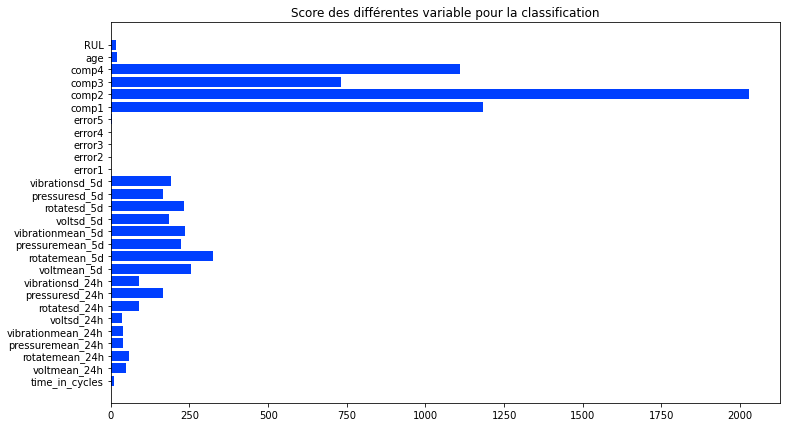

In [24]:
from sklearn.feature_selection import SelectKBest

fs = SelectKBest()
tested_cols = ['time_in_cycles', 'voltmean_24h',
       'rotatemean_24h', 'pressuremean_24h', 'vibrationmean_24h', 'voltsd_24h',
       'rotatesd_24h', 'pressuresd_24h', 'vibrationsd_24h', 'voltmean_5d',
       'rotatemean_5d', 'pressuremean_5d', 'vibrationmean_5d', 'voltsd_5d',
       'rotatesd_5d', 'pressuresd_5d', 'vibrationsd_5d', 'error1', 'error2',
       'error3', 'error4', 'error5', 'comp1', 'comp2', 'comp3', 'comp4',
       'age', 'RUL']
fs.fit_transform(data_train[tested_cols], data_train['failure'])

plt.figure(figsize=(12, 7))
plt.barh(y=tested_cols, width=fs.scores_);

plt.title('Score des différentes variable pour la classification');


Les colonnes numériques ```voltmean_5d```, ```rotatemean_5d```, ```pressuremean_5d```, ```vibrationmean_5d``` ont l'air particulièrement significatives, elles sont de plus résonables à estimer lors d'un processus industriel en faisant une moyenne glissante sur 5 jours. Nous allons également rajouter les colonnes ```age``` et ```time_in_cycle``` qui semblent importantes pour la gestion d'un park de machines. Les colonnes one hot ```comp1```, ```comp2```, ```comp3```, et ```comp4``` ont l'air particulièrement significatives. Nous allons les utiliser pour notre classification.

## 3. Préparation des données

Nous allons maintenant préparer nos données pour appliquer des algorithmes de classification. Nous allons isoler les colonnes qui nous intéressent et nous allons générer deux autres jeux de données : un jeu de données avec un effective de classe majoritaire réduit (que nous désignerons par la suite "jeu réduit") et  un jeu de données avec un effective de classes minoritaires augmenté (que nous désignerons par la suite "jeu augmenté").

In [25]:
# on commence par isoler les colonnes qui nous intéressent
num_cols = ['voltmean_5d', 'rotatemean_5d', 'pressuremean_5d', 'vibrationmean_5d', 'time_in_cycles', 'age']
oh_cols = ['comp1', 'comp2', 'comp3', 'comp4'] # ['error1', 'error2', 'error4', 'error5']

X_train, y_train = data_train[num_cols + oh_cols], data_train['failure']
X_test, y_test = data_test[num_cols + oh_cols], data_test['failure']
X_train.head()

voltmean_5d  rotatemean_5d  pressuremean_5d  vibrationmean_5d  \
2980     -0.219203      -2.722030         0.336606          0.302421   
22093     1.728445      -0.003583         0.207067          3.334785   
17481    -0.740224       0.325587        -0.437953         -0.055299   
10577    -0.636627       0.314705        -0.596051         -0.361954   
26670    -0.263954       0.341924        -0.101778         -0.820324   

       time_in_cycles       age  comp1  comp2  comp3  comp4  
2980        -1.335052 -1.392430      0      0      0      0  
22093        0.977652  1.494488      0      0      0      0  
17481        0.407396  0.475576      0      0      0      0  
10577       -0.437428 -0.713155      0      0      0      0  
26670        1.621829 -1.392430      0      0      0      0

Au vu de la disparité des classes, nous allons également créer un jeu de données avec un effectif réduit pour la classe 0. On fixe effective de la classe 0 = effectif de toutes les autres classes x 2. Ce choix est arbitraire, il serait de plus intéressant de le faire varier. Une limitation de cette approche est que nous limitons grandement l'échantillon d'entrainement.

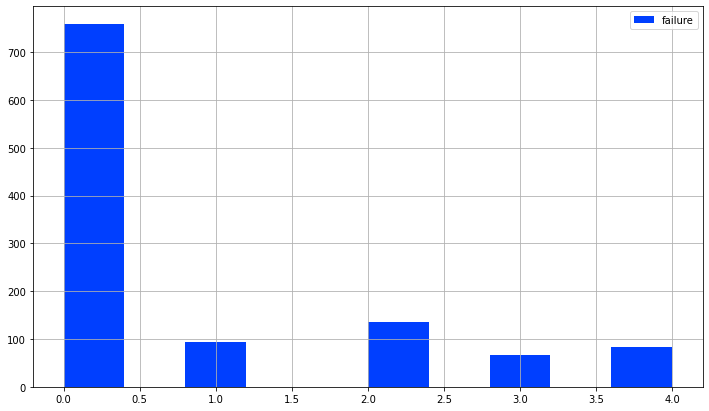

In [26]:
nb_failures = X_train.join(y_train)[X_train.join(y_train)['failure'] > 0].shape[0]
data_train_reduced = X_train.join(y_train)[X_train.join(y_train)['failure'] > 0].append(X_train.join(y_train)[X_train.join(y_train)['failure'] == 0].sample(n=nb_failures*2))
X_train_reduced, y_train_reduced = data_train_reduced.iloc[:, :-1], data_train_reduced.iloc[:, -1]
data_train_reduced['failure'].hist(figsize=(12, 7), legend='failure');

Une autre possibilité est d'augmenter l'effectif des classes minoritaires en générant des données synthétiques. La librairie SMOTE permet de faire cela facilement. Nous allons générer un nouveau jeu de données d'entrainement avec cette librairie et l'enregistrer au format CSV pour pouvoir le réutiliser sans avoir à executer le code utilisant SMOTE plus tard si besoin. Nous allons limiter la taille totale du jeu de données généré de sorte à ce que la taille du nouveau jeu de données généré n'excède pas (ou presque pas) la taille du jeu de données initial

In [27]:
# A n'executer qu'une seule fois
# from imblearn.over_sampling import SMOTE

# data_sample = X_train.join(y_train).sample(X_train.shape[0]//4, random_state=42)
# X_train_sample, y_train_sample = data_sample.iloc[:, :-1], data_sample.iloc[:, -1]
# sm = SMOTE(random_state=42)
# X_train_smote, y_train_smote = sm.fit_resample(X_train_sample, y_train_sample)
# X_train_smote.join(y_train_smote).to_csv('train_data_smote.csv', index=False)

# X_train_smote.shape

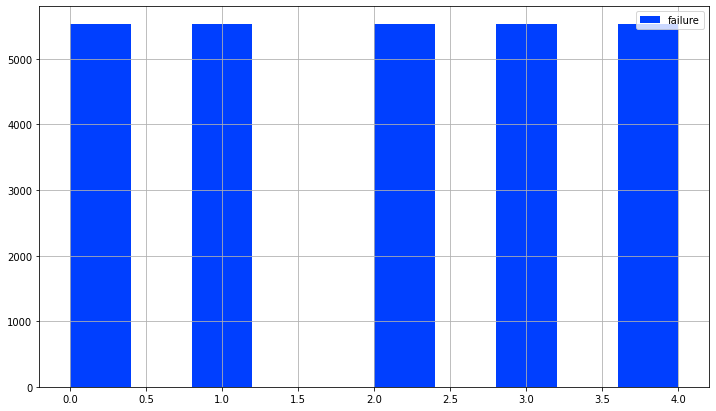

In [28]:
data_augmented = pd.read_csv('train_data_smote.csv')
X_train_augmented, y_train_augmented = data_augmented.iloc[:, :-1], data_augmented.iloc[:, -1]
data_augmented['failure'].hist(figsize=(12, 7), legend='failure');

Dans la suite nous allons essayer plusieurs classifieurs sur les 3 jeux de données pour voir comment évoluent les résultats et voir si une approche est meilleure qu'une autre.

# 2. Classification

Le choix de la metrique d'évaluation est important pour la suite afin de pouvoir comparer les différents algorithmes. Dans notre cas, nous voulons surtout éviter les faux négatifs, afin d'éviter de passer à côté d'éventuelles pannes. Dans ce genre de situation on définie le score $F_\beta$ comme suit :
$$
F_\beta = (1+\beta^2) \frac{precision \cdot recall}{(\beta^2 \cdot precision + recall)}
$$

Une valeur usuelle pour privilégier le taux de recalls est $\beta$ = 2. Dans la suite nous allons donc utiliser cette métrique, ainsi que la métrique pour $\beta$ = 1 (F-score équilibré) à titre de comparaison.

Pour plus d'informations sur le F-score voir la [documentation officielle de Sklearn](https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics).

Nous allons commencer par définir une fonction permettant tester plusieurs valeurs d'un paramètre sur un estimateur afin de déterminer la valeur qui maximise le score.

In [29]:
from sklearn.metrics import fbeta_score

# on définie une fonction qui permet de chercher la meilleure valeur d'un paramètre pour un classifieur
def plot_scores_param(X_train, X_test, y_train, y_test, estimator, param_name, param_range, other_params={}):
    f2_score = []
    score = []
    for p in param_range:
        classifier = estimator(**{param_name:p}, **other_params)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)

        f2_score.append((fbeta_score(y_test, y_pred, average='macro', beta=2)))
        score.append(classifier.score(X_test, y_test))

    best_param = np.argmax(f2_score)

    plt.figure(figsize=(10, 6));
    plt.plot(param_range, score, label='mse', color='grey', linestyle='dashed');
    plt.plot(param_range, f2_score, label='f2 score');
    plt.scatter(param_range[best_param], f2_score[best_param], label='f2 min', marker='x', s=100, color='red')
    plt.legend();
    plt.title('f2 and mse = f(k)');
    plt.show();

    print('Meilleur f2 score={:.2f} optenu pour {}={:.2f}'.format(f2_score[best_param], param_name, param_range[best_param]))

    classifier = estimator(**{param_name:param_range[best_param]})
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    sns.heatmap(pd.crosstab(y_test, y_pred), annot=True, fmt='d', cmap='turbo');
    plt.title('Resultats avec {}={:.2f}'.format(param_name, param_range[best_param]));
    plt.show();

    return param_name, param_range[best_param], f2_score[best_param]

# on crée une variable dans laquelle nous allons stocker nos résultats au fur et à mesure.
classifier_scores = pd.DataFrame(columns=['Classifieur', 'f2 score', 'f2 score sur réduit', 'f2 score sur augmenté'])

### Clustering : $k$-means

Un premier algorithme vu en classe est le k-means. Par curiosité essayons de tracer la courbe du coude vue en classe pour tenter d'identifier la meilleure valeur de k. Ici nous avons déjà un objectif sur le nombre de classes, mais nous pouvons quand même essayer pour voir à quoi cela ressemble sur notre jeu de données et surtout voir si on observe un coude autour de k = 5.

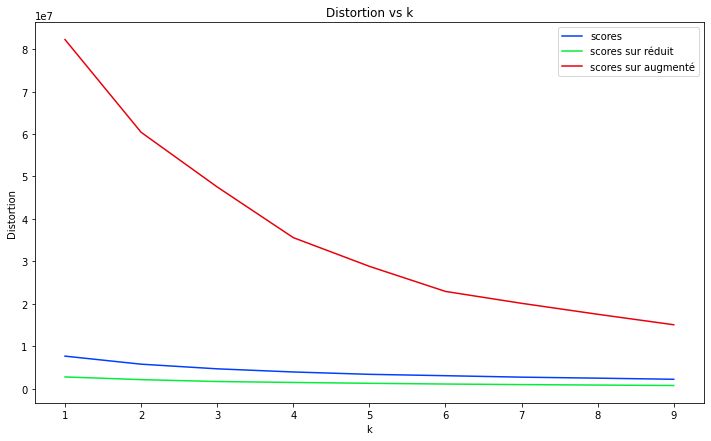

In [30]:
elbow_scores = []
elbow_scores_reduced = []
elbow_scores_augmented = []

k_range = list(range(1, 10))
# on prend une valeur de k entre 1 et 10
for k in k_range:
    # On fait touner le k-means pour chaque valeur de k
    kmeans_algo = cluster.KMeans(n_clusters=k)
    kmeans_algo.fit_transform(X_train)
    # on fait une liste des scores
    elbow_scores.append(kmeans_algo.inertia_)

    # on en fait de même pour le jeu réduit
    kmeans_algo.fit_transform(X_train_reduced)
    elbow_scores_reduced.append(kmeans_algo.inertia_)

    # on en fait de même pour le jeu réduit
    kmeans_algo.fit_transform(X_train_augmented)
    elbow_scores_augmented.append(kmeans_algo.inertia_)


# On affiche nos score en fonction de k
plt.figure(figsize=(12, 7));
plt.plot(k_range, elbow_scores, label='scores')
plt.plot(k_range, elbow_scores_reduced, label='scores sur réduit')
plt.plot(k_range, elbow_scores_augmented, label='scores sur augmenté')
plt.xlabel("k");
plt.ylabel("Distortion");
plt.legend();
plt.title('Distortion vs k');

On ne constate pas de coude évident, ce qui laisse présager qu'il sera difficile de classer nos données en plusieurs classes. Il est intéressant de noter qu'après plusieurs tests avec différentes colonnes du jeu de données, ce graphe donne une bonne première idée de la performance relative des algorithmes de classification. Plus le coude est marqué, plus il semble que les algorithmes de classification vont obtenir un meilleur score.

Essayons de faire touner un k-means avec 5 clusters pour voir si l'algorithme arrive a découper le jeu de données entre les 5 classes : 1 classe pour pas d'échec, et 4 classes pour les 4 types d'échec

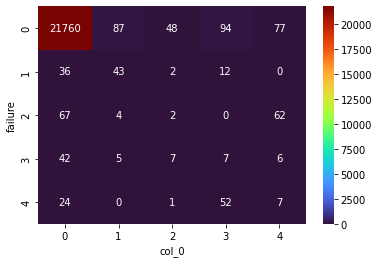

In [31]:
# on applique l'algorithme k-means
#on essaie d'identifier 5 groupes
kmeans_algo = cluster.KMeans(n_clusters=5)
kmeans_results = kmeans_algo.fit_transform(X_train)

# on peut afficher une heatmap pour émuler une matrice de confusion
sns.heatmap(pd.crosstab(y_train, kmeans_algo.labels_), annot=True, fmt='d', cmap='turbo');

Comme prévu l'algorithme ne présente pas de très bon résultats. Tournons-nous vers des algorithmes plus adaptés à notre problème.

### Classifieurs Ensemblistes
### 1. Random Forest Classifier

Un premier classifieur que nous pouvons essayer sur notre jeu de données est le Random Forest Classifier. Ce classifieur possède un paramètre n_estimators que nous allons essayer d'optimiser.

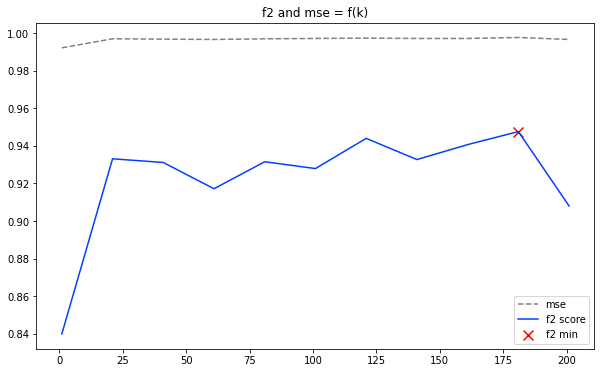

Meilleur f2 score=0.95 optenu pour n_estimators=181.00


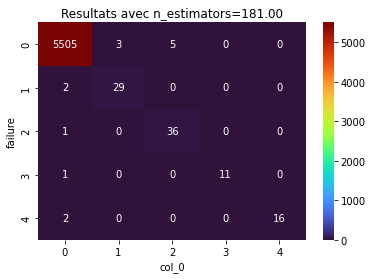

In [32]:
from sklearn.ensemble import RandomForestClassifier

n_range = list(range(1, 220, 20))
_, _, best_f2 = plot_scores_param(X_train, X_test, y_train, y_test, RandomForestClassifier, 'n_estimators', n_range);

Ce classificateur obtient un bon score, et le parametre n_estimators semble avoir peu d'influence sur le score passé une certaine valeur (20/25). Essayons sur le jeu de données réduit.

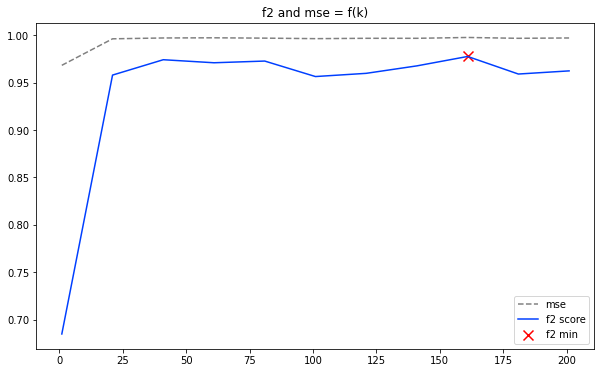

Meilleur f2 score=0.98 optenu pour n_estimators=161.00


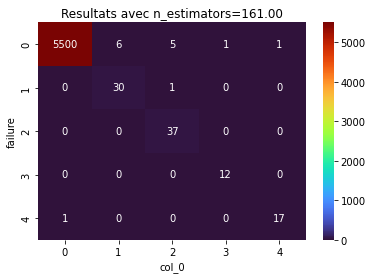

In [33]:
_, _, best_f2_red = plot_scores_param(X_train_reduced, X_test, y_train_reduced, y_test, RandomForestClassifier, 'n_estimators', n_range);

Le classifieur retourne des résultats équivalents, voire parfois meilleurs une fois entrainé sur les données d'entrainement avec un effectif de classe 0 réduit.

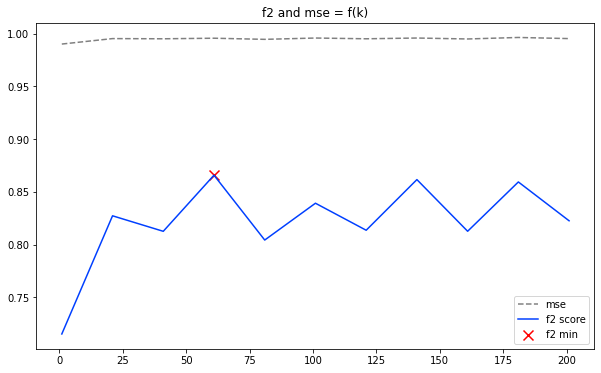

Meilleur f2 score=0.87 optenu pour n_estimators=61.00


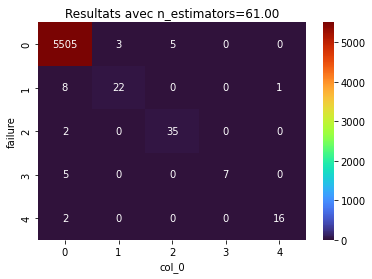

In [34]:
_, _, best_f2_augm = plot_scores_param(X_train_augmented, X_test, y_train_augmented, y_test, RandomForestClassifier, 'n_estimators', n_range);
classifier_scores = classifier_scores.append({'Classifieur': 'RandomForestClassifier', 'f2 score':best_f2, 'f2 score sur réduit': best_f2_red, 'f2 score sur augmenté': best_f2_augm}, ignore_index=True)

Nous obtenons des résultats moins bons avec le jeu de données augmenté.

### Classifieurs Ensemblistes
### 2. Gradient Boosting Classifier

C'est le classifieur qui semble être privilégié d'après la litérature pour ce type d'application. Il présente plusieurs paramètres ajustables. Nous allons essayer d'en ajuster trois. PLut^ot que de faire une echerche par quadrillage (grid search) qui serait longue à calculer nous allons essayer d'ajuster un paramètre après l'autre en gardant à chaque fois la meilleure valeur de chaque paramètre.

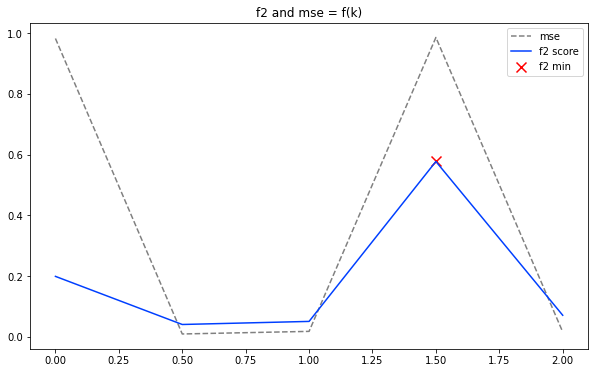

Meilleur f2 score=0.58 optenu pour learning_rate=1.50


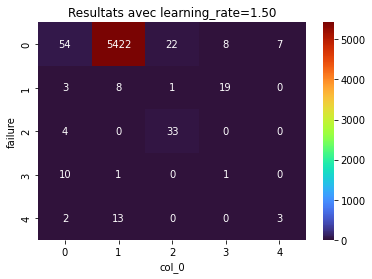

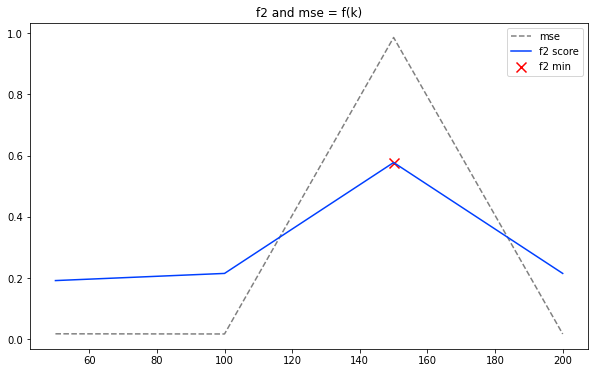

Meilleur f2 score=0.58 optenu pour n_estimators=150.00


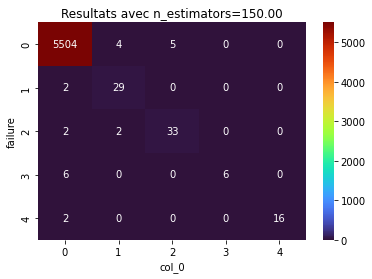

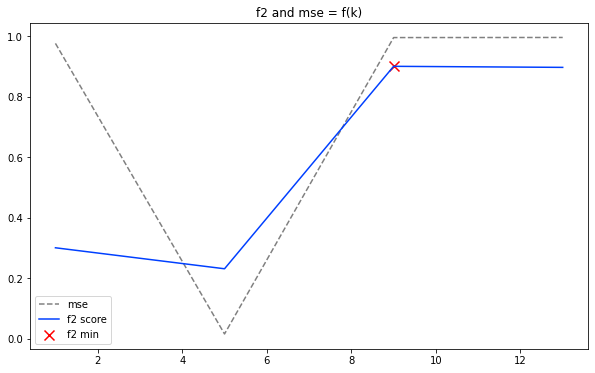

Meilleur f2 score=0.90 optenu pour max_depth=9.00


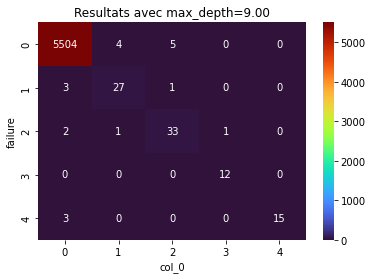

In [35]:
# peut mettre 5 min à s'executer sur un PC relativement puissant.
from sklearn.ensemble import GradientBoostingClassifier

l_range = np.linspace(1e-3, 2, num=5)
_, l_value, _ = plot_scores_param(X_train, X_test, y_train, y_test, GradientBoostingClassifier, 'learning_rate', l_range, {'n_estimators':100, 'max_depth':3})

n_range = list(range(50, 201, 50))
_, n_value, _= plot_scores_param(X_train, X_test, y_train, y_test, GradientBoostingClassifier, 'n_estimators', n_range, {'learning_rate':l_value, 'max_depth':3});

m_range = list(range(1, 14, 4))
_, _, best_f2 = plot_scores_param(X_train, X_test, y_train, y_test, GradientBoostingClassifier, 'max_depth', m_range, {'n_estimators':n_value, 'learning_rate':l_value});

On voit qu'avec les bons paramètres ce classifieur peut donner de bons résultats.

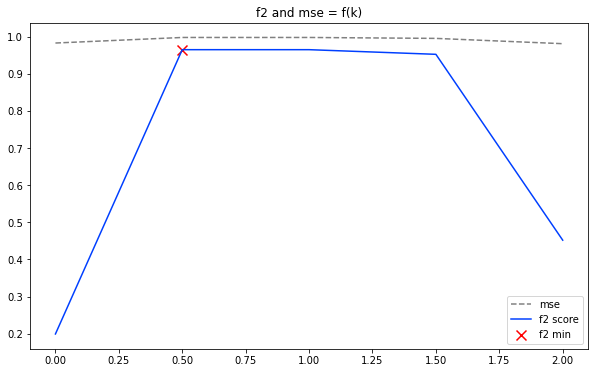

Meilleur f2 score=0.96 optenu pour learning_rate=0.50


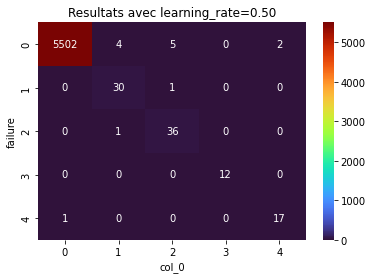

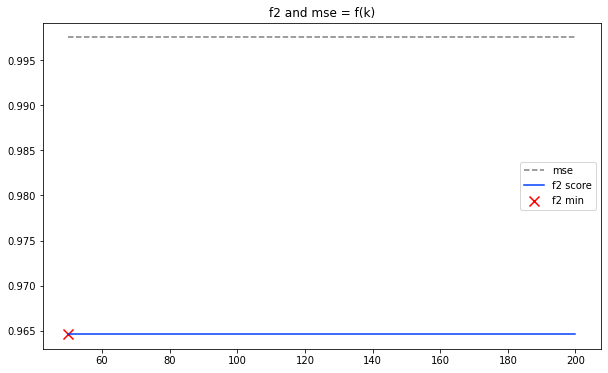

Meilleur f2 score=0.96 optenu pour n_estimators=50.00


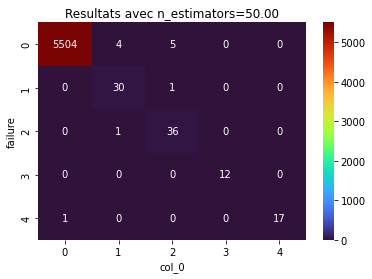

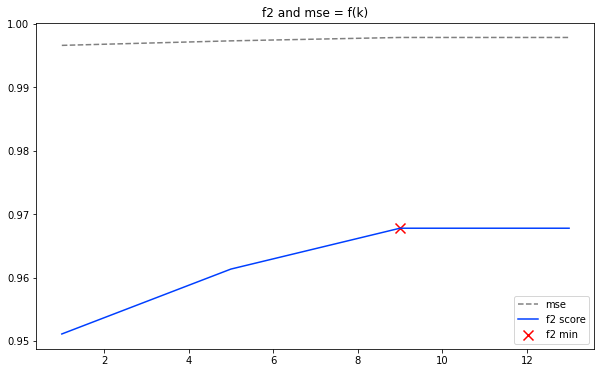

Meilleur f2 score=0.97 optenu pour max_depth=9.00


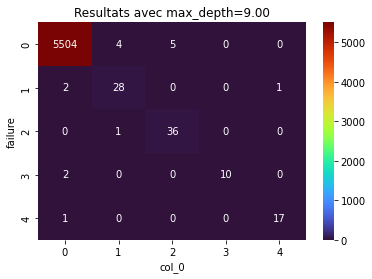

In [36]:
_, l_value, _ = plot_scores_param(X_train_reduced, X_test, y_train_reduced, y_test, GradientBoostingClassifier, 'learning_rate', l_range, {'n_estimators':100, 'max_depth':3})

_, n_value, _ = plot_scores_param(X_train_reduced, X_test, y_train_reduced, y_test, GradientBoostingClassifier, 'n_estimators', n_range, {'learning_rate':l_value, 'max_depth':3});

_,_, best_f2_red = plot_scores_param(X_train_reduced, X_test, y_train_reduced, y_test, GradientBoostingClassifier, 'max_depth', m_range, {'n_estimators':n_value, 'learning_rate':l_value});

Essayons finalement avec le jeu de données réduit.

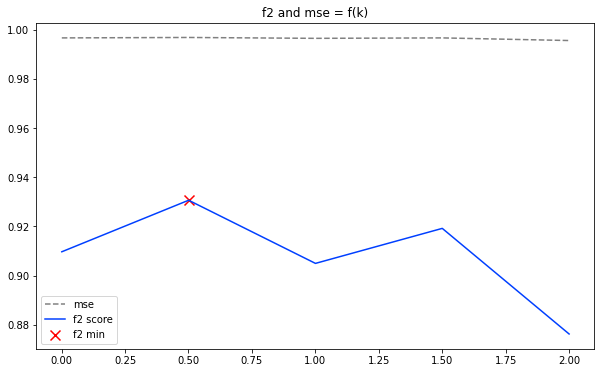

Meilleur f2 score=0.93 optenu pour learning_rate=0.50


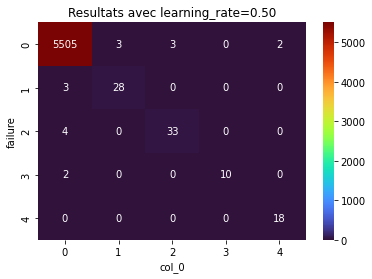

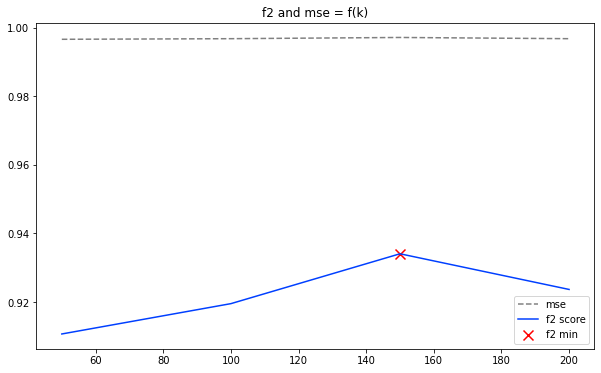

Meilleur f2 score=0.93 optenu pour n_estimators=150.00


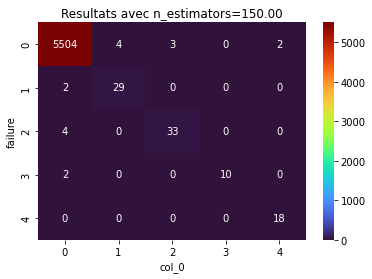

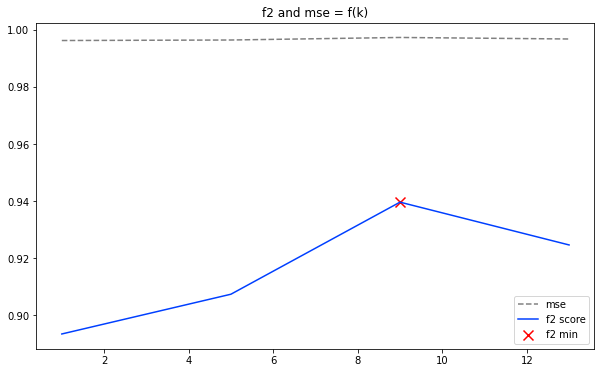

Meilleur f2 score=0.94 optenu pour max_depth=9.00


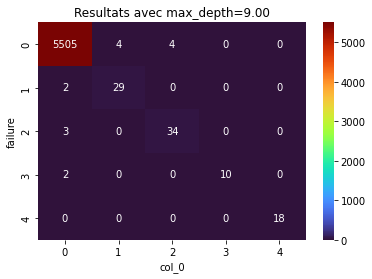

In [37]:
_, l_value, _ = plot_scores_param(X_train_augmented, X_test, y_train_augmented, y_test, GradientBoostingClassifier, 'learning_rate', l_range, {'n_estimators':100, 'max_depth':3})

_, n_value, _ = plot_scores_param(X_train_augmented, X_test, y_train_augmented, y_test, GradientBoostingClassifier, 'n_estimators', n_range, {'learning_rate':l_value, 'max_depth':3});

_,_, best_f2_augm = plot_scores_param(X_train_augmented, X_test, y_train_augmented, y_test, GradientBoostingClassifier, 'max_depth', m_range, {'n_estimators':n_value, 'learning_rate':l_value});

classifier_scores = classifier_scores.append({'Classifieur': 'GradientBoostingClassifier', 'f2 score':best_f2, 'f2 score sur réduit': best_f2_red, 'f2 score sur augmenté': best_f2_augm}, ignore_index=True)

Ce classifieur retourne un score variable, il possède de nombreux paramètres à ajuster, ce qui peut s'avérer délicat à optimiser. Le fait de réduire le nombre d'occurences de la classe dominante semble améliorer la matrice de confusion (plus de valeurs diagonales). Il est intéressant de noter que les valeurs optimales des paramètres varient suivant le jeu de données utilisé.

### Classifieurs Ensemblistes à arbre de décision : Decision Tree Classifier

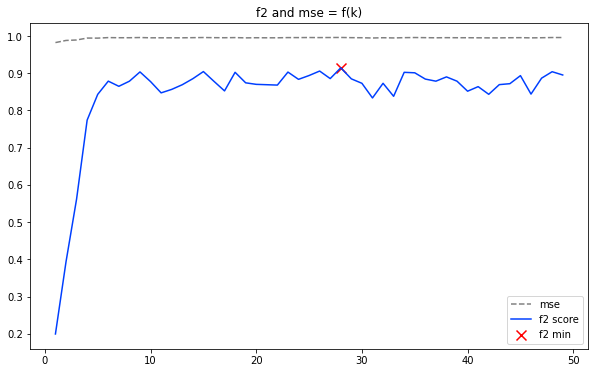

Meilleur f2 score=0.91 optenu pour max_depth=28.00


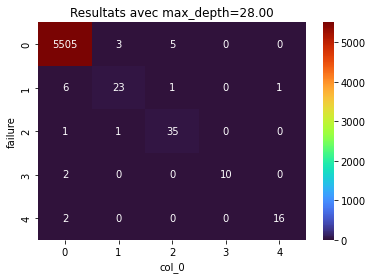

In [38]:
from sklearn.tree import DecisionTreeClassifier

m_range = list(range(1, 50))
_,_,best_f2 = plot_scores_param(X_train, X_test, y_train, y_test, DecisionTreeClassifier, 'max_depth', m_range);

Observons maintenant les résultats sur le jeu de données réduit.

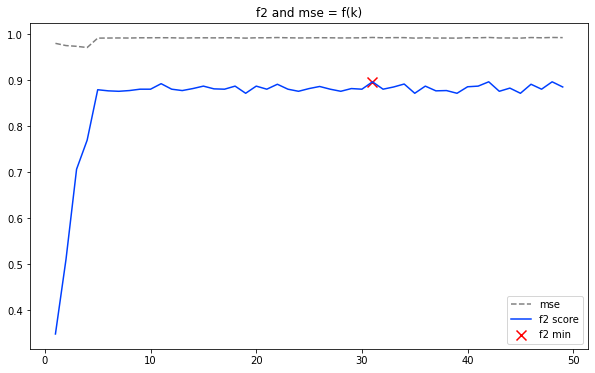

Meilleur f2 score=0.90 optenu pour max_depth=31.00


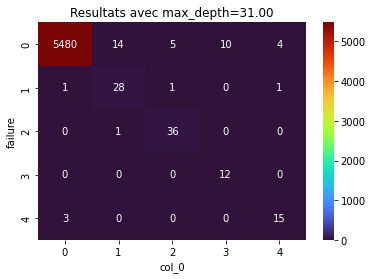

In [39]:
_,_,best_f2_red = plot_scores_param(X_train_reduced, X_test, y_train_reduced, y_test, DecisionTreeClassifier, 'max_depth', m_range);

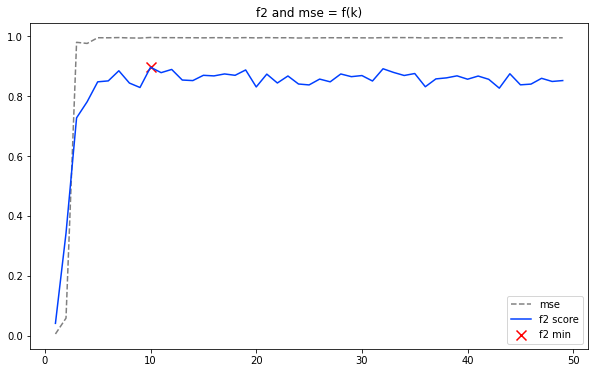

Meilleur f2 score=0.90 optenu pour max_depth=10.00


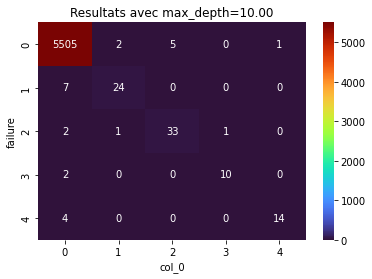

In [40]:
_, _, best_f2_augm = plot_scores_param(X_train_augmented, X_test, y_train_augmented, y_test, DecisionTreeClassifier, 'max_depth', m_range);

classifier_scores = classifier_scores.append({'Classifieur': 'DecisionTreeClassifier', 'f2 score':best_f2, 'f2 score sur réduit': best_f2_red, 'f2 score sur augmenté': best_f2_augm}, ignore_index=True)

On constate que ce classifieur peut retourner de bons résultats, surtout avec le jeu de données réduit.

### Classifieur naïf : Gaussian Naive Bayes 

Essayons de classifier nos données à l'aide du classifieur Gaussian Naive Bayes. Ce classifeur possède un paramètre 'smoothing' à ajuster. Nous allons essayer plusieurs valeurs de ce paramètre pour voir quelle valeur retourne le meilleur score.

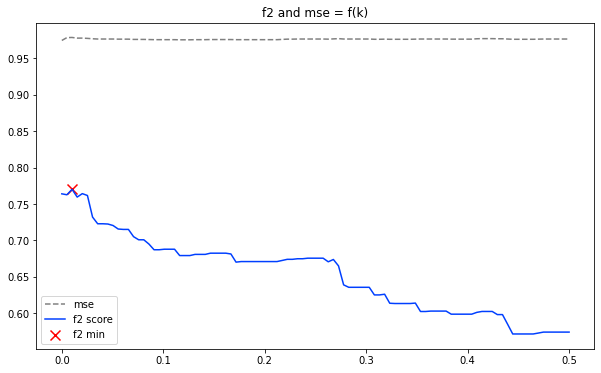

Meilleur f2 score=0.77 optenu pour var_smoothing=0.01


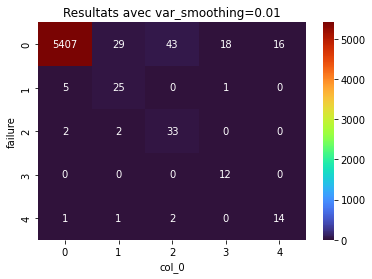

In [41]:
from sklearn.naive_bayes import GaussianNB

s_range = np.linspace(1e-9, 0.5, num=100)
_,_,best_f2 = plot_scores_param(X_train, X_test, y_train, y_test, GaussianNB, 'var_smoothing', s_range);

Les résultats sont moins bons qu'avec d'autres classifieurs. Essayons de faire la même chose avec les données réduites.

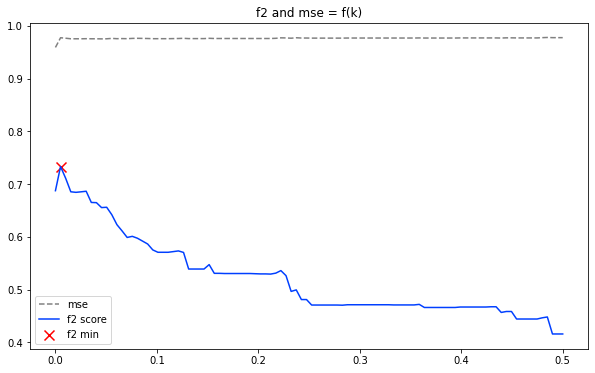

Meilleur f2 score=0.73 optenu pour var_smoothing=0.01


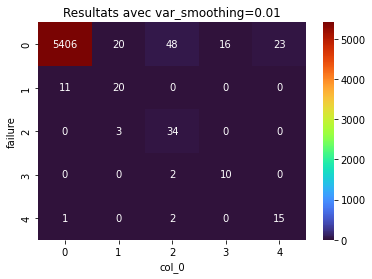

In [42]:
_,_,best_f2_red = plot_scores_param(X_train_reduced, X_test, y_train_reduced, y_test, GaussianNB, 'var_smoothing', s_range);

On constate une amélioration des résultats avec le jeu réduit ce qui est intéressant.

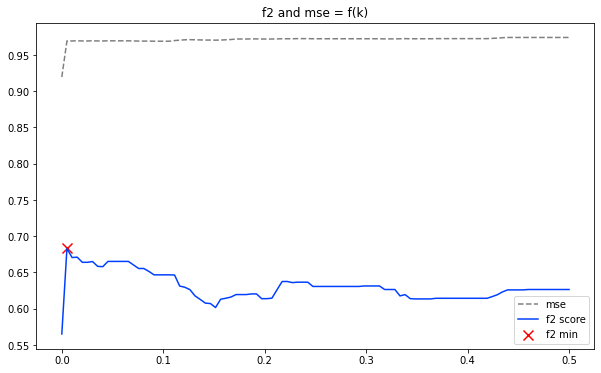

Meilleur f2 score=0.68 optenu pour var_smoothing=0.01


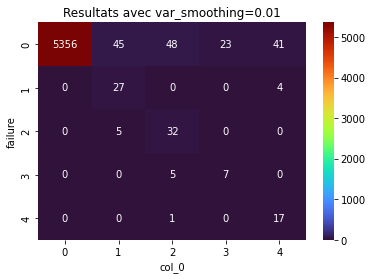

In [43]:
_, _, best_f2_augm = plot_scores_param(X_train_augmented, X_test, y_train_augmented, y_test, GaussianNB, 'var_smoothing', s_range);

classifier_scores = classifier_scores.append({'Classifieur': 'GaussianNB', 'f2 score':best_f2, 'f2 score sur réduit': best_f2_red, 'f2 score sur augmenté': best_f2_augm}, ignore_index=True)

### Classifieurs non linéaires
### 1. K-Voisins

Essayons de classifier nos données à l'aide de la méthode des plus proches voisins

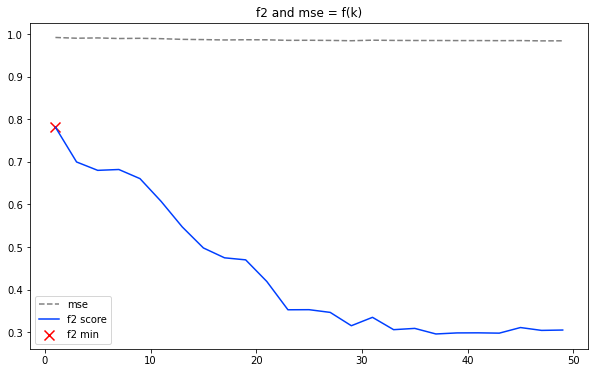

Meilleur f2 score=0.78 optenu pour n_neighbors=1.00


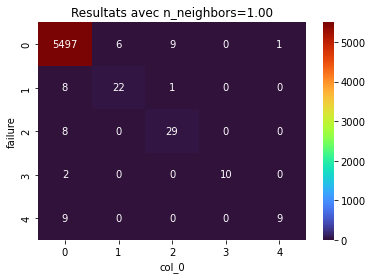

In [44]:
from sklearn.neighbors import KNeighborsClassifier

n_range = range(1, 50, 2)
_,_,best_f2 = plot_scores_param(X_train, X_test, y_train, y_test, KNeighborsClassifier, 'n_neighbors', n_range);

Le meilleur score est souvent obtenu pour n = 1 (suivant la graine aléatoire), ce qui est souvent le cas avec cet algorithme. C'est la valeur qui minimise le biais. Voyons comme le classifieur se comporte avec le jeu de données réduit.

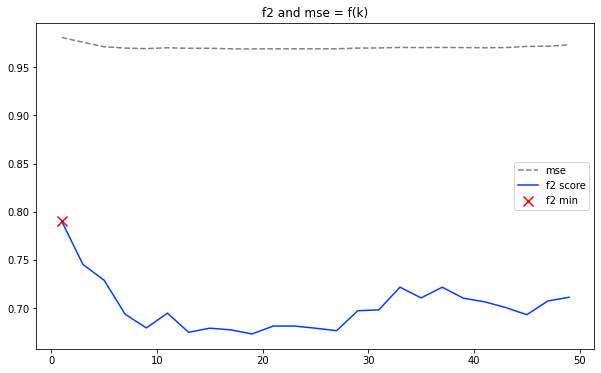

Meilleur f2 score=0.79 optenu pour n_neighbors=1.00


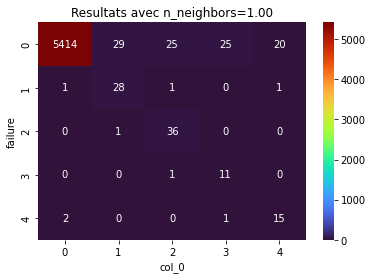

In [45]:
_,_,best_f2_red = plot_scores_param(X_train_reduced, X_test, y_train_reduced, y_test, KNeighborsClassifier, 'n_neighbors', n_range);

Ce classifieur donne un meilleur score une fois entrainé sur le jeu de données réduit, voyons comment il se comporte sur le jeu de données augmenté.

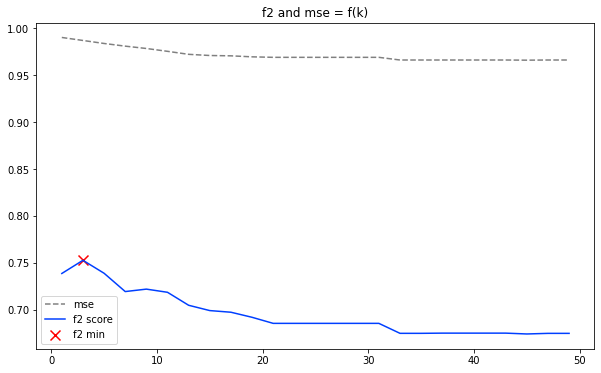

Meilleur f2 score=0.75 optenu pour n_neighbors=3.00


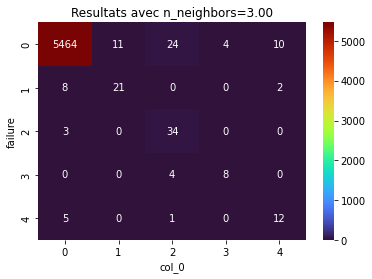

In [46]:
_, _, best_f2_augm = plot_scores_param(X_train_augmented, X_test, y_train_augmented, y_test, KNeighborsClassifier, 'n_neighbors', n_range);

classifier_scores = classifier_scores.append({'Classifieur': 'KNeighborsClassifier', 'f2 score':best_f2, 'f2 score sur réduit': best_f2_red, 'f2 score sur augmenté': best_f2_augm}, ignore_index=True)

### Classifieurs non linéaires
### 2. Linear Discriminant Analysis

Nous n'avons cette fois-ci pas de paramètres à ajuster. Nous allons simplement comparer les résultats entre le modèle ajuster sur le jeu complet vs le jeu réduit.

Fb score avec X_train: 0.76
Fb score avec X_train_reduced: 0.76
Fb score avec X_train_augmented: 0.44


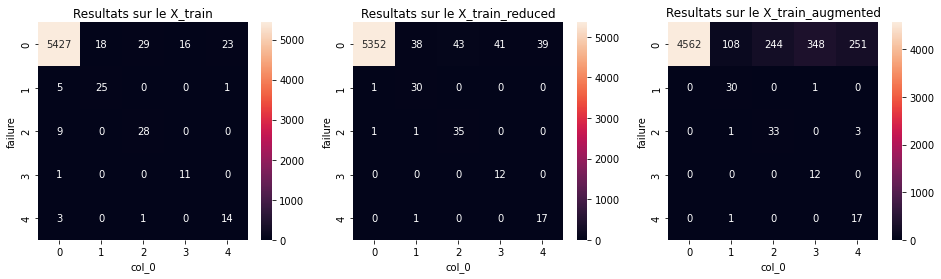

In [47]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_classifier = LinearDiscriminantAnalysis()
lda_classifier.fit(X_train, y_train)
y_pred = lda_classifier.predict(X_test)
best_f2 = fbeta_score(y_test, y_pred, average='macro', beta=2)

fig = plt.figure(figsize=(16,4))
axes = fig.subplots(nrows=1, ncols=3)

sns.heatmap(pd.crosstab(y_test, y_pred), annot=True, fmt='d', ax=axes[0], cmap='turbo') ;
axes[0].set_title('Resultats sur le X_train');
print('Fb score avec X_train: {:.2f}'.format(best_f2))

lda_classifier.fit(X_train_reduced, y_train_reduced)
y_pred = lda_classifier.predict(X_test)
best_f2_red = fbeta_score(y_test, y_pred, average='macro', beta=2)

sns.heatmap(pd.crosstab(y_test, y_pred), annot=True, fmt='d', ax=axes[1], cmap='turbo');
axes[1].set_title('Resultats sur le X_train_reduced');

print('Fb score avec X_train_reduced: {:.2f}'.format(best_f2_red))

lda_classifier.fit(X_train_augmented, y_train_augmented)
y_pred = lda_classifier.predict(X_test)
best_f2_augm = fbeta_score(y_test, y_pred, average='macro', beta=2)

sns.heatmap(pd.crosstab(y_test, y_pred), annot=True, fmt='d', ax=axes[2], cmap='turbo');
axes[2].set_title('Resultats sur le X_train_augmented');

print('Fb score avec X_train_augmented: {:.2f}'.format(best_f2_augm))

classifier_scores = classifier_scores.append({'Classifieur': 'LinearDiscriminantAnalysis', 'f2 score':best_f2, 'f2 score sur réduit': best_f2_red, 'f2 score sur augmenté': best_f2_augm}, ignore_index=True)

Ce classifieur ne necessaite de plus pas d'ajuster des paramètres ce qui est intéressant, mais il retourne des résultats moins bons comparé aux autres algorithmes. L'entrainement sur le jeu de données augmenté donne des résultats très mauvais.

### Classifieurs non linéaires
### 3. Support Vector Machine

Nous pouvons ajuster le paramètre C sur ce modèle.

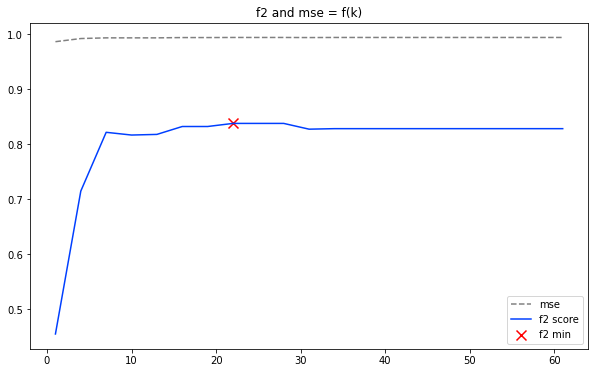

Meilleur f2 score=0.84 optenu pour C=22.00


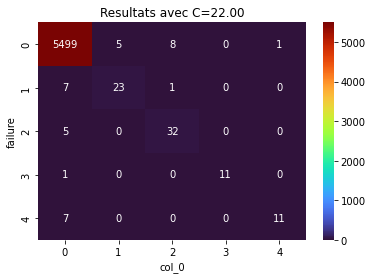

In [48]:
from sklearn.svm import SVC

c_range = list(range(1, 63, 3))
_,_,best_f2 = plot_scores_param(X_train, X_test, y_train, y_test, SVC, 'C', c_range);

Observons les résultats sur le jeu réduit.

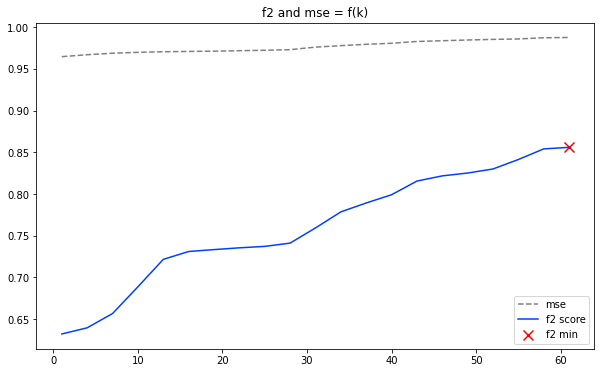

Meilleur f2 score=0.86 optenu pour C=61.00


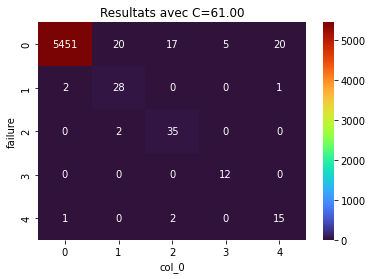

In [49]:
_,_,best_f2_red = plot_scores_param(X_train_reduced, X_test, y_train_reduced, y_test, SVC, 'C', c_range);

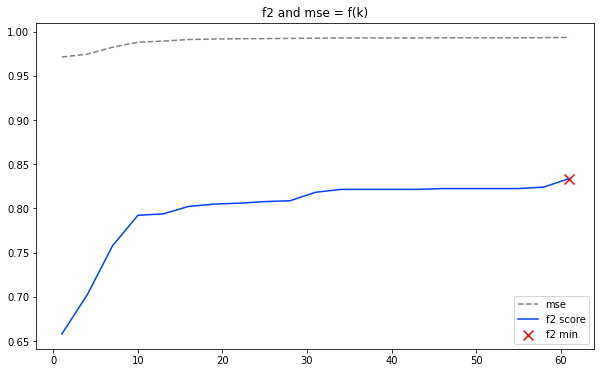

Meilleur f2 score=0.83 optenu pour C=61.00


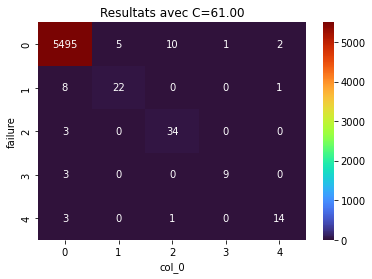

In [50]:
_,_,best_f2_augm = plot_scores_param(X_train_augmented, X_test, y_train_augmented, y_test, SVC, 'C', c_range);
classifier_scores = classifier_scores.append({'Classifieur': 'SVC', 'f2 score':best_f2, 'f2 score sur réduit': best_f2_red, 'f2 score sur augmenté': best_f2_augm}, ignore_index=True)

C'est un des rares classifeurs qui semble avoir de moins bons résultats sur le jeu réduit.

### Classifieurs linéaires
### 1. SGDClassifier

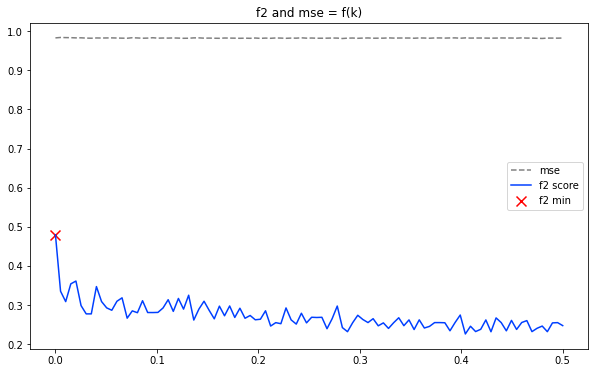

Meilleur f2 score=0.48 optenu pour alpha=0.00


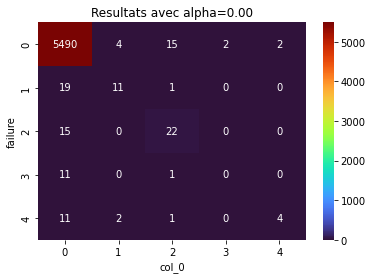

In [51]:
from sklearn.linear_model import SGDClassifier

a_range = np.linspace(1e-5, 0.5, num=100)
_,_,f2_score = plot_scores_param(X_train, X_test, y_train, y_test, SGDClassifier, 'alpha', a_range);

Ce classifieur semble tout attribuer à la classe majoritaire. Voyons sont comportement sur le jeu de données réduit.

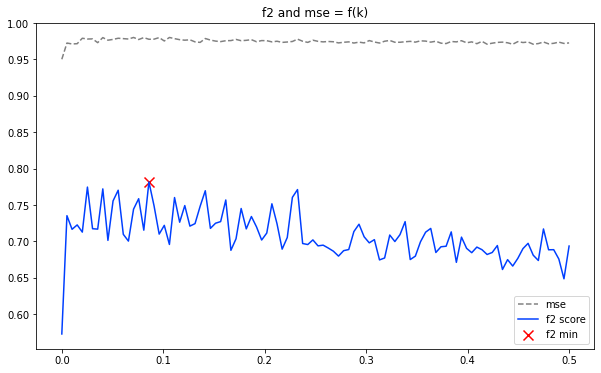

Meilleur f2 score=0.78 optenu pour alpha=0.09


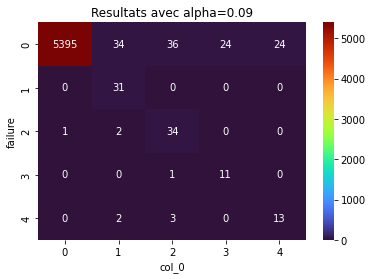

In [52]:
_,_,best_f2_red = plot_scores_param(X_train_reduced, X_test, y_train_reduced, y_test, SGDClassifier, 'alpha', a_range);

Les résultats sont bien meilleurs sur le jeu de données réduit, voyons maintenant les résultats sur le jeu augmenté.

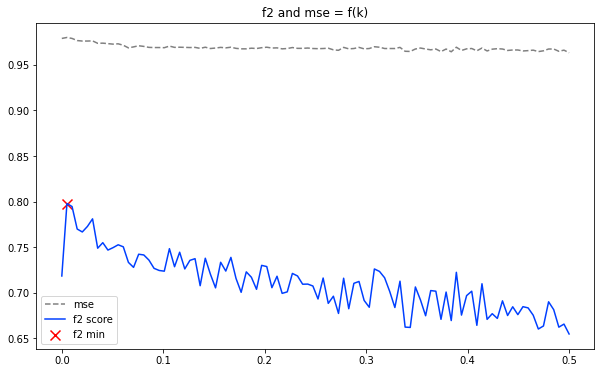

Meilleur f2 score=0.80 optenu pour alpha=0.01


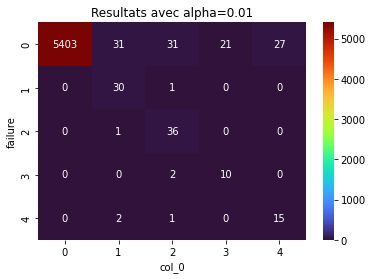

In [53]:
_,_,best_f2_augm = plot_scores_param(X_train_augmented, X_test, y_train_augmented, y_test, SGDClassifier, 'alpha', a_range);
classifier_scores = classifier_scores.append({'Classifieur': 'SGDClassifier', 'f2 score':best_f2, 'f2 score sur réduit': best_f2_red, 'f2 score sur augmenté': best_f2_augm}, ignore_index=True)

On obtient des résultats légèrement meilleurs avec le jeu augmenté.

### Classifieurs linéaires
### 2. Logistic Regression

Ce classifieur permet d'ajouter un paramètre de poids, nous allons donc tester plusieurs valeurs poids sur la classe majoritaire 0.

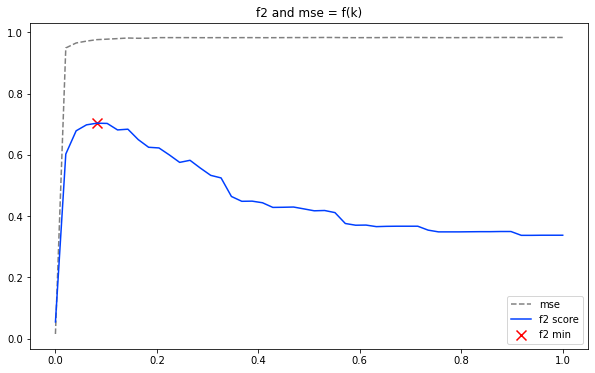

Meilleur f2 score=0.70 optenu pour weight=0.08


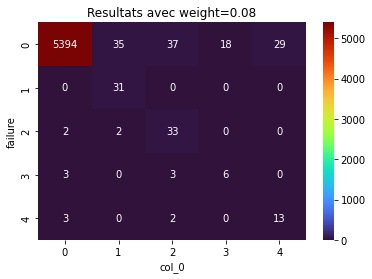

In [54]:
from sklearn.linear_model import LogisticRegression

# on ignore les warnings éventuels
import warnings
warnings.filterwarnings("ignore")

# on définit une fonction qui permet de s'interfacer avec plot_scores_param
def logistic_regression_w(weight):
    return LogisticRegression(class_weight={0: weight}, solver='saga')

w_range = np.linspace(1e-5, 1, num=50)
_,_,best_f2 = plot_scores_param(X_train, X_test, y_train, y_test, logistic_regression_w, 'weight', w_range);

Observons maintenant les résultats sur le jeu réduit.

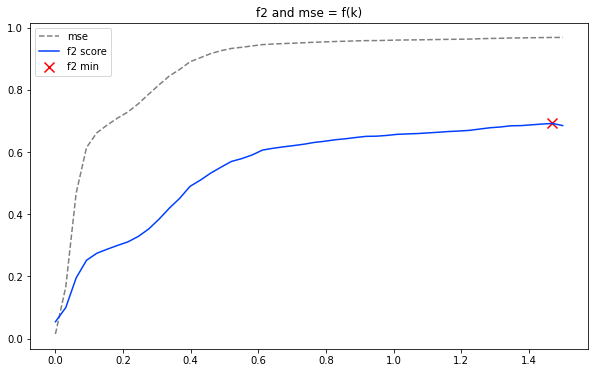

Meilleur f2 score=0.69 optenu pour weight=1.47


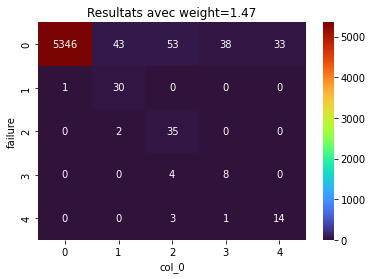

In [55]:
w_range = np.linspace(1e-4, 1.5, num=50)
_,_,best_f2_red = plot_scores_param(X_train_reduced, X_test, y_train_reduced, y_test, logistic_regression_w, 'weight', w_range);

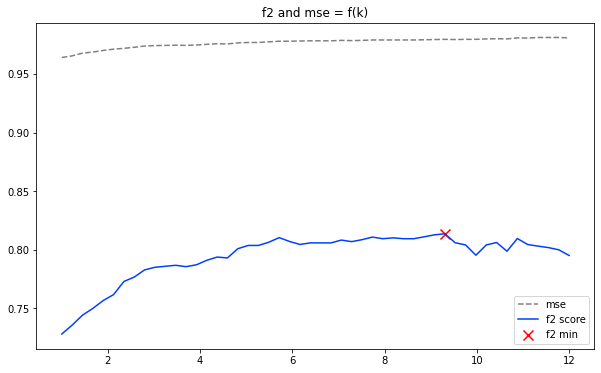

Meilleur f2 score=0.81 optenu pour weight=9.31


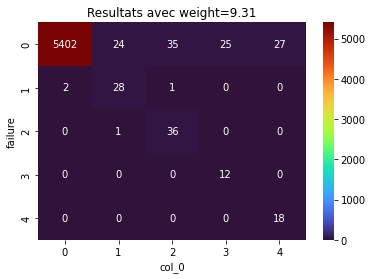

In [56]:
w_range = np.linspace(1, 12, num=50)
_,_,best_f2_augm = plot_scores_param(X_train_augmented, X_test, y_train_augmented, y_test, logistic_regression_w, 'weight', w_range);

classifier_scores = classifier_scores.append({'Classifieur': 'LogisticRegression', 'f2 score':best_f2, 'f2 score sur réduit': best_f2_red, 'f2 score sur augmenté': best_f2_augm}, ignore_index=True)

On constate que le poids attribué à la classe majoritaire est proche de 1 sur le jeu réduit et proche de 6 sur le jeu augmenté. Ce classifieur est le seul jusqu'à maintenant qui permette d'ajuster le poids de la classe majoritaire.

In [57]:
classifier_scores.to_csv('scores_comparison.csv')
classifier_scores

Classifieur  f2 score  f2 score sur réduit  \
0      RandomForestClassifier  0.947612             0.977795   
1  GradientBoostingClassifier  0.900689             0.967776   
2      DecisionTreeClassifier  0.914681             0.896579   
3                  GaussianNB  0.770147             0.733355   
4        KNeighborsClassifier  0.781327             0.789858   
5  LinearDiscriminantAnalysis  0.756929             0.756417   
6                         SVC  0.837470             0.855866   
7               SGDClassifier  0.837470             0.781801   
8          LogisticRegression  0.703283             0.691761   

   f2 score sur augmenté  
0               0.865831  
1               0.939640  
2               0.896799  
3               0.683107  
4               0.752546  
5               0.441599  
6               0.833691  
7               0.797981  
8               0.813602

De tous les classifeurs testés, c'est le RandomForestClassifier qui a obtenu le meilleur score, obtenu sur le jeu réduit. Il faut cependant rester prudent sur ce score, le jeu réduit contenant moins de données d'entrainement, le modèle obtenu avec celui-ci a une plus grande variabilité, et on peut le considérer comme moins fiable sur de nouvelles données.

 Il est intéressant d'observer que les algorithmes ne réagissent pas de la même façon sur le jeu de données initial, le jeu réduit et le jeu augmenté. Certains classieurs semblent avoir un meilleur score sur le jeu réduit, mais puisque ce jeu de données présente beaucoup moins de données que le jeu initial, on risque d'avoir une plus grande variabilité des résultats. La plupart des classifieurs ont un score moins élevé lorsqu'ils sont entrainés sur le jeu augmenté avec la métjode SMOTE. 

### Conclusion : choix du modèle

Au vu des résultats précédents, nous allons sélectionner le RandomForestClassifier avec ```n_estimators=200```. C'est en effet le classifieur qui retourne les meilleurs résultats et de façon consistente (pour plusieurs graines aleatoires). Nous allons maintenant l'entrainer sur le jeu complet, comme c'est le choix qui donne des résultats les plus fiables (plus grand échantillon d'entrainenemnt) et l'enregistrer pour pouvoir le charger directement et l'utiliser dans une application industrielle. Nous allons de plus étudier ses performances plus en détail et le comparer aux même modèle entrainé sur les jeux réduits et augmentés.

In [58]:
rfc_classifier = rfc_classifier_reduced = rfc_classifier_augmented = RandomForestClassifier(n_estimators=200)

# jeu complet
rfc_classifier.fit(X_train, y_train)
pickle.dump(rfc_classifier, open('rfc_classifier.pkl', 'wb'))
y_pred = rfc_classifier.predict(X_test)
pred_proba = rfc_classifier.predict_proba(X_test)

# jeu réduit
rfc_classifier_reduced.fit(X_train_reduced, y_train_reduced)
y_pred_reduced = rfc_classifier_reduced.predict(X_test)
pred_proba_reduced = rfc_classifier_reduced.predict_proba(X_test)

# jeu augmenté
rfc_classifier_augmented.fit(X_train_augmented, y_train_augmented)
y_pred_augmented = rfc_classifier_augmented.predict(X_test)
pred_proba_augmented = rfc_classifier_augmented.predict_proba(X_test)

Pour évaluer plus en détail les performances du modèle, nous pouvons tracer les courbes ROC par classe et afficher les scores AUC.

0: Aire sous la courbe (AUC)=0.999
4: Aire sous la courbe (AUC)=0.733
3: Aire sous la courbe (AUC)=0.859
2: Aire sous la courbe (AUC)=0.541
1: Aire sous la courbe (AUC)=0.586
Moyenne : Aire sous la courbe (AUC)=0.743


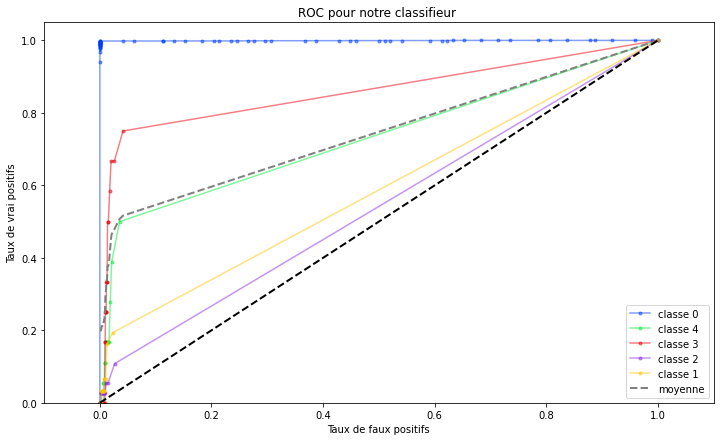

0: Aire sous la courbe (AUC)=0.999
4: Aire sous la courbe (AUC)=0.740
3: Aire sous la courbe (AUC)=0.822
2: Aire sous la courbe (AUC)=0.530
1: Aire sous la courbe (AUC)=0.521
Moyenne : Aire sous la courbe (AUC)=0.722


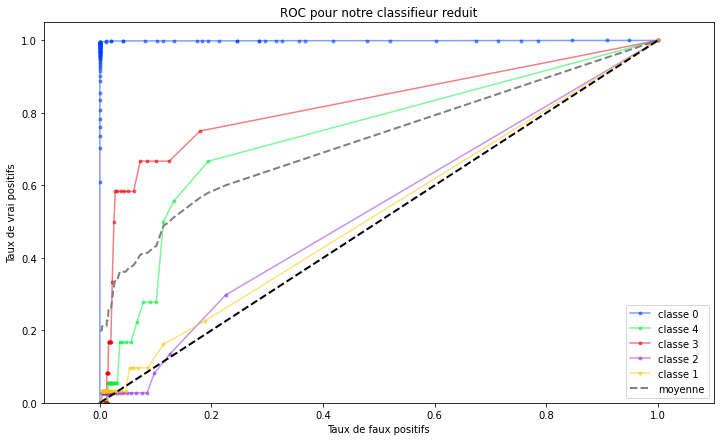

0: Aire sous la courbe (AUC)=0.999
4: Aire sous la courbe (AUC)=0.615
3: Aire sous la courbe (AUC)=0.811
2: Aire sous la courbe (AUC)=0.540
1: Aire sous la courbe (AUC)=0.609
Moyenne : Aire sous la courbe (AUC)=0.715


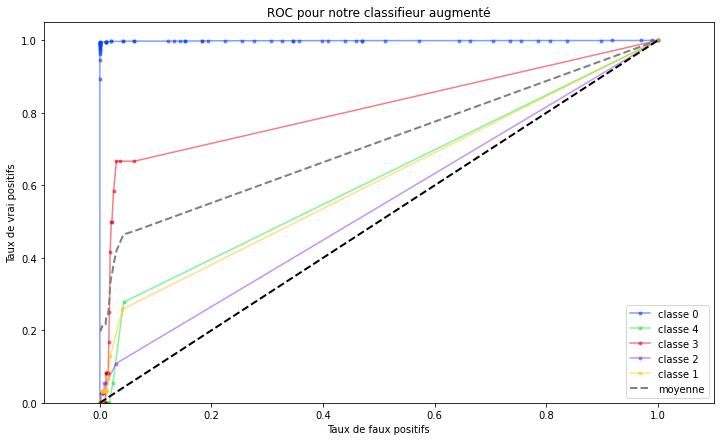

In [59]:
from sklearn.metrics import roc_curve, auc

def plt_roc_auc(y_test, y_pred, pred_proba, name=''):
    # ROC et AUC
    fpr = {}
    tpr = {}
    roc_auc = {}
    classes = y_test.unique()
    n_classes = len(classes)

    plt.figure(figsize=(12, 7))
    # calcul des scores
    for i, c in enumerate(classes):
        fpr[i], tpr[i], _ = roc_curve(y_test, pred_proba[:,i], pos_label=c)
        roc_auc[i] = auc(fpr[i], tpr[i])

        # affichage des scores
        print('{}: Aire sous la courbe (AUC)={:.3f}'.format(c, roc_auc[i]))

        # on trace la courbe ROC par classe
        plt.plot(fpr[i], tpr[i], marker='.', label='classe '+str(c), alpha=0.5)

    # on définit la courbe ROC macro, cf doc officielle de sklearn :
    # https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Interpolation de toutes les courbes ROC
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Calcul de la moyenne
    mean_tpr /= n_classes
    fpr['macro'], tpr['macro']  = all_fpr, mean_tpr
    roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

    print('Moyenne : Aire sous la courbe (AUC)={:.3f}'.format(roc_auc['macro']))

    # on trace la courbe moyenne
    plt.plot(fpr['macro'], tpr['macro'], label='moyenne', linestyle="dashed", color='grey', lw=2)

    # on rajoute la diagonale
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlim((-0.1, 1.1))

    # un peu de mise en forme ...
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrai positifs')

    plt.title('ROC pour notre classifieur '+name)
    plt.legend();
    plt.show();

plt_roc_auc(y_test, y_pred, pred_proba)
plt_roc_auc(y_test, y_pred_reduced, pred_proba_reduced, 'reduit')
plt_roc_auc(y_test, y_pred_augmented, pred_proba_augmented, 'augmenté')

Il est intéressant de noter que la performance de notre modèle dépend fortement de la classe. On obtient un très bon score AUC sur la classe 0, et moins bon sur les classes minoritaires. Il est aussi très intéressant de noter l'allure des différentes courbes ROC en fonction du jeu d'entrainement. Le jeu réduit peut parfois donner un meilleur score f2 mais la courbe ROC globale est et l'aire sous la courbe moyenne sont moins bonnes. On constate de plus que chaque la différence dans l'allule de la courbe ROC varie aussi suivant les classes.

Cela confirme notre intuition que le modèle entrainé sur le jeu complet est le plus performant et le robuste.

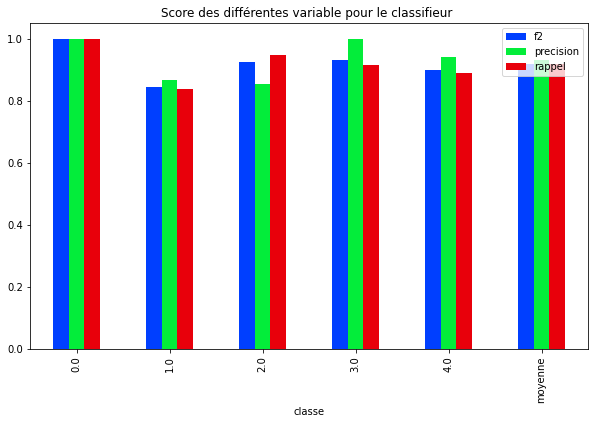

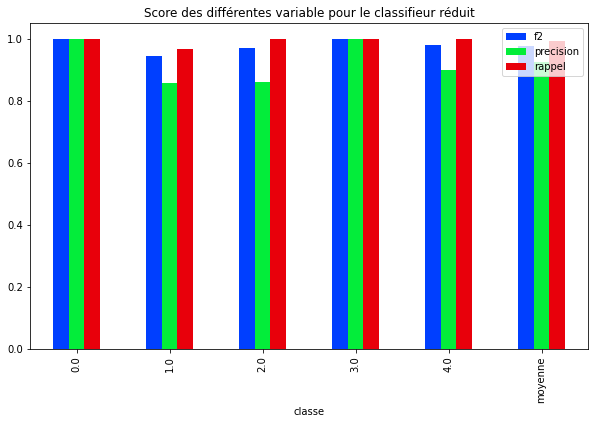

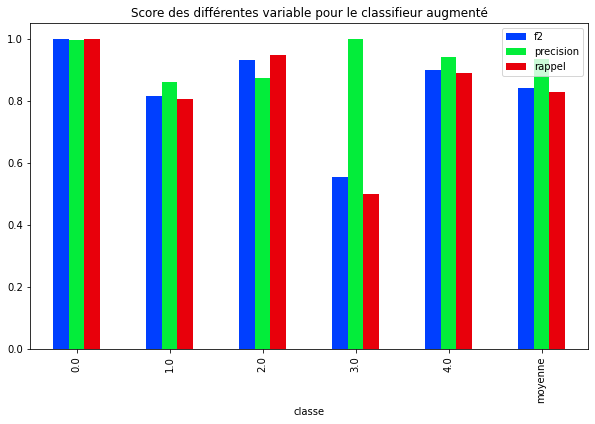

In [60]:
from sklearn.metrics import precision_score, recall_score

# on définit une fonction pour afficher les scores
def plot_scores(y_test, y_pred, name=''):
    classes = sorted(y_test.unique())

    df_scores = pd.DataFrame(columns=['classe', 'f2', 'precision', 'rappel'])
    # On calculer les précision et taux de rappel par classe
    for c in classes:
        prec = precision_score(y_test==c, y_pred==c)
        rec = recall_score(y_test==c, y_pred==c)
        f2 =  fbeta_score(y_test==c, y_pred==c, beta=2)
        df_scores = df_scores.append({'classe': c, 'f2':f2, 'precision': prec, 'rappel': rec}, ignore_index=True)
        #print('{} (total {}): f2={:.2%}, precision={:.2%}, recall={:.2%}'.format(c, ((y_test==c).sum()), f2, prec, rec))

    # calcul des scores moyens
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    f2 =  fbeta_score(y_test, y_pred, average='macro', beta=2)
    df_scores = df_scores.append({'classe': 'moyenne', 'f2':f2, 'precision': prec, 'rappel': rec}, ignore_index=True)

    # tracé du graphe
    df_scores.plot(x='classe', y=['f2', 'precision', 'rappel'], kind='bar', figsize=(10, 6));
    plt.title('Score des différentes variable pour le classifieur ' + name);

# jeu complet
plot_scores(y_test, y_pred)

# jeu réduit
plot_scores(y_test, y_pred_reduced, 'réduit')

# jeu augemnté
plot_scores(y_test, y_pred_augmented, 'augmenté')

On constate que l'on obtient les meilleurs scores sur le jeu modèle entrainé à partir du jeu réduit, encore une fois cela montre que le score n'est qu'une partie de l'histoire et ne permet pas de capturer tous les aspects de la performance d'un classifieur.

## Partie 3 : Explicabilité du modèle

Nous sommes maintenant en mesure de faire des prédictions. Pour aller plus loin il serait intéressant de pouvoir expliquer notre modèle. Lorsqu'une prédiction de panne est faite dans un environnement industriel, cela peut necessiter l'intervention d'une équipe de maintenance coûteuse. Il serait intéressant de pouvoir comprendre ce qui a déclanché la prédiction d'une panne et pouvoir éventuellement aiguiller le technicien de maintenance sur le point à vérifier.

Pour cela nous allons utiliser la librairie shap. Afin de similer la détection d'une panne nous allons sélectionner un point des données de test qui correspond à une panne et prédire une valeur en ce point, ce qui devrait retourner une panne. Nous allons ensuite utiliser la librairie shap afin d'expliquer les features qui ont influencées la décision.

In [61]:
import shap

shap.initjs()

# on simule la détection d'une panne
data_sample = X_test.join(y_test)
data_sample = data_sample[data_sample['failure'] > 0].sample(1)
X_test_sample, y_test_sample = data_sample.iloc[:, :-1], data_sample.iloc[:, -1]

# on charge notre modèle
rfc_classifier = pickle.load(open('rfc_classifier.pkl', 'rb'))
y_pred_sample = rfc_classifier.predict(X_test_sample)
print('Prédiction : classe {}'.format(y_pred_sample[0]))

# On explique la prédiction avec shap
explainer = shap.KernelExplainer(rfc_classifier.predict_proba, X_train.sample(500))
shap_values = explainer.shap_values(X_test_sample)
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test_sample)

Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prédiction : classe 3


100%|██████████| 1/1 [00:05<00:00,  5.36s/it]


On otient ainsi un diagramme qui décrut l'influence de nos feature sur la prédiction. La mesure capteur mise en avant peut donner un indice à l'équipe de maintenance sur ce qu'il faut inspecter.